<a href="https://colab.research.google.com/github/konupark/CSCB_Final_Project23/blob/main/CSCB_Final_Component3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Component 3: 
PIP-seq involves a vortexing step that seems like it may damage cells. Compare the PIP-seq breast tissue data against the 10X breast tissue data. What are the main differences in cell counts and gene expression in each population? Is any cell population especially strongly affected? You can get the data from GEO records GSM7074401 (10X) and GSM6620702 (PIP-seq), or you can use the starter code below.

In [1]:
# access my Google drive from Google Colab
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!pip install scanpy
!python -m pip uninstall -y matplotlib
!pip install matplotlib==3.1.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 55.6 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.1.3
    Uninstalling matplotlib-3.1.3:
      Successfully uninstalled matplotlib-3.1.3


Found existing installation: matplotlib 3.7.1
Uninstalling matplotlib-3.7.1:
  Successfully uninstalled matplotlib-3.7.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached matplotlib-3.1.3-cp310-cp310-linux_x86_64.whl
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scanpy 1.9.3 requires matplotlib>=3.4, but you have matplotlib 3.1.3 which is incompatible.
plotnine 0.10.1 requires matplotlib>=3.5.0, but you have matplotlib 3.1.3 which is incompatible.
mizani 0.8.1 requires matplotlib>=3.5.0, but you have matplotlib 3.1.3 which is incompatible.
arviz 0.15.1 requires matplotlib>=3.2, but you have matplotlib 3.1.3 which is incompatible.


In [3]:
!pip install python-igraph leidenalg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!pip install --upgrade anndata

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import pandas as pd
import scanpy as sc
import numpy as np
import anndata as ad

In [6]:
## set seed for reproducibility
seed = 0
np.random.seed(seed)

### Load marker genes

In [7]:
breast_marker_genes_dict = {
    "Fibroblast": ["DCN", "MMP2", "PDPN"],
    "LEP1": ["ALDH1A3", "LTF", "PROM1", "ESR1", "PGR"],
    "LEP2": ["KRT19", "ELF3", "MUC1", "AGR2", "ANKRD30A", "TFF3", "ESR1", "PGR"],
    "Myoepithelial": ["KRT14", "KRT17", "TP63", "ACTA2"],
    "Macrophage": ["CD14", "CD16", "CD64", "CD68", "CD71", "CCL3"],
    "Dendritic cell": ["LY75", "CCR7"],
    "Vascular accessory": ["RGS5"],
    "Endothelial": ["ANGPT2", "CDH5", "CLDN5"],
    "Lymphocyte": ["CD52", "CXCR4", "CD3D", "CD8A", "PTPRC"]
}

### Load dataset

In [8]:
# Breast 10x data
!wget https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM7074nnn/GSM7074403/suppl/GSM7074403_KP_cDNA_3_barcodes.tsv.gz
!wget https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM7074nnn/GSM7074403/suppl/GSM7074403_KP_cDNA_3_features.tsv.gz
!wget https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM7074nnn/GSM7074403/suppl/GSM7074403_KP_cDNA_3_matrix.mtx.gz
breast_10x     = sc.read_mtx("GSM7074403_KP_cDNA_3_matrix.mtx.gz").T
breast_10x.obs = pd.read_csv("GSM7074403_KP_cDNA_3_barcodes.tsv.gz", header = None, sep = "\t")
breast_10x.var = pd.read_csv("GSM7074403_KP_cDNA_3_features.tsv.gz", header = None, sep = "\t")
breast_10x

# Breast PIP-seq data
!wget https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM6620nnn/GSM6620702/suppl/GSM6620702_JZ_20211118_FR_1.zip
!unzip GSM6620702_JZ_20211118_FR_1.zip
breast_pip     = sc.read_mtx("force_17691/matrix.mtx").T
breast_pip.obs = pd.read_csv("force_17691/barcodes.tsv", header = None, sep = "\t")
breast_pip.var = pd.read_csv("force_17691/genes.tsv",    header = None, sep = "\t")
breast_pip

--2023-05-08 18:38:27--  https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM7074nnn/GSM7074403/suppl/GSM7074403_KP_cDNA_3_barcodes.tsv.gz
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.12, 130.14.250.13, 2607:f220:41f:250::230, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.12|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4226 (4.1K) [application/x-gzip]
Saving to: ‘GSM7074403_KP_cDNA_3_barcodes.tsv.gz’

GSM7074403_KP_cDNA_ 100%[===================>]   4.13K  --.-KB/s    in 0s      

2023-05-08 18:38:27 (111 MB/s) - ‘GSM7074403_KP_cDNA_3_barcodes.tsv.gz’ saved [4226/4226]

--2023-05-08 18:38:27--  https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM7074nnn/GSM7074403/suppl/GSM7074403_KP_cDNA_3_features.tsv.gz
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.12, 130.14.250.13, 2607:f220:41f:250::230, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.12|:443... connected.
HTTP request se

AnnData object with n_obs × n_vars = 17691 × 61114
    obs: 0
    var: 0, 1

In [9]:
breast_10x

AnnData object with n_obs × n_vars = 792 × 21823
    obs: 0
    var: 0, 1, 2

In [10]:
breast_pip

AnnData object with n_obs × n_vars = 17691 × 61114
    obs: 0
    var: 0, 1

#### Assign gene names for downstream analysis

In [34]:
## load ensemble ID dataset
file_path = '/content/gdrive/MyDrive/CSCB final/mart_export.txt'

df = pd.read_csv(file_path, delimiter='\t')

# replace empty strings with None
df['Gene name'] = df['Gene name'].fillna(df['Gene stable ID'])

# convert dataframe to dictionary
ensemble_dict = df.set_index('Gene stable ID').to_dict()['Gene name']

In [35]:
## breast_10x
breast_10x.var[1] = breast_10x.var[0].map(ensemble_dict).astype('category')
breast_10x.var_names = breast_10x.var[1]

/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:879: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['ENSG00000238009', 'ENSG00000239945', 'LINC01409', 'FAM87B', 'LINC00115']

    Inferred to be: categorical

  names = self._prep_dim_index(names, "var")


In [36]:
## breast_pip
breast_pip.var_names = breast_pip.var[1]

/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:879: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['DDX11L1', 'WASH7P', 'MIR6859-1', 'MIR1302-2HG', 'MIR1302-2']

    Inferred to be: categorical

  names = self._prep_dim_index(names, "var")


In [40]:
## rename column names
breast_10x.obs.rename(columns={0:"CellID"}, inplace = True)
breast_10x.var.rename(columns={0:"Gene stable ID", 1:"Gene name", 2:"column 2"}, inplace = True)
breast_pip.obs.rename(columns={0:"CellID"}, inplace = True)
breast_pip.var.rename(columns={0:"Gene stable ID", 1:"Gene name"}, inplace = True)

### Export data set

In [44]:
breast_10x.write('/content/gdrive/MyDrive/CSCB final/breast_10x_preanalysis.h5ad')
breast_pip.write('/content/gdrive/MyDrive/CSCB final/breast_pip_preanalysis.h5ad')

### Import data sets
Use if restarting the code after running the starter codes)

In [8]:
breast_10x = sc.read_h5ad('/content/gdrive/MyDrive/CSCB final/breast_10x_preanalysis.h5ad')
breast_pip = sc.read_h5ad('/content/gdrive/MyDrive/CSCB final/breast_pip_preanalysis.h5ad')

/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationW

In [9]:
breast_10x

AnnData object with n_obs × n_vars = 792 × 21823
    obs: 'cellID'
    var: 'Gene stable ID', 'Gene name', 'column 2'

In [10]:
breast_pip

AnnData object with n_obs × n_vars = 17691 × 61114
    obs: 'CellID'
    var: 'Gene stable ID', 'Gene name'

### Store raw data

In [11]:
## store raw data
breast_10x.raw = breast_10x
breast_pip.raw = breast_pip

### Characterization

#### breast_10x 

In [12]:
## run scanpy QC metrics
breast_10x.var["mito"] = breast_10x.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(breast_10x, qc_vars=["mito"], inplace=True)

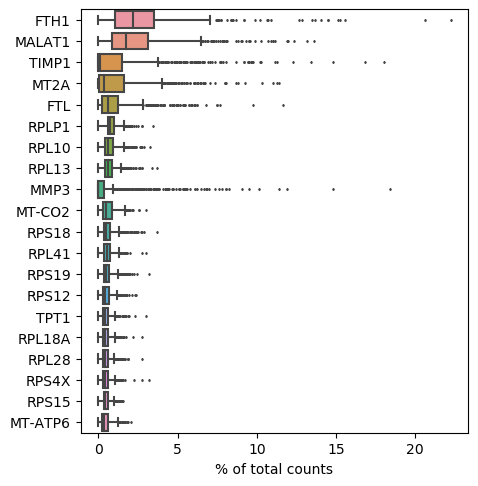

In [13]:
## top 20 highest expressed genes
sc.pl.highest_expr_genes(breast_10x, n_top=20)

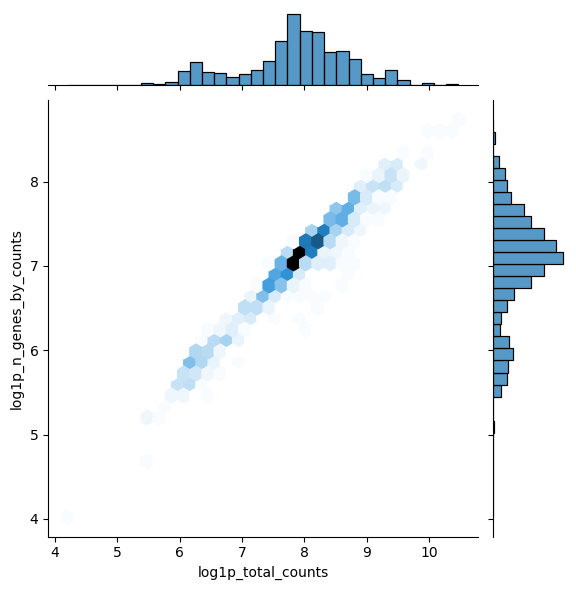

In [14]:
## plot correlation between log10 total counts and log10 number of unique genes
sns.jointplot(
    data=breast_10x.obs,
    x="log1p_total_counts",
    y="log1p_n_genes_by_counts",
    kind="hex",
)

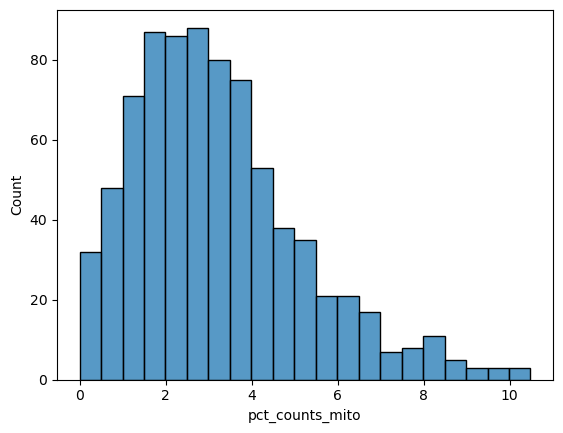

In [15]:
## plot histogram of % counts of mitochondrial gene
sns.histplot(breast_10x.obs["pct_counts_mito"])

#### breast_pip

In [16]:
## run scanpy QC metrics
breast_pip.var["mito"] = breast_pip.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(breast_pip, qc_vars=["mito"], inplace=True)

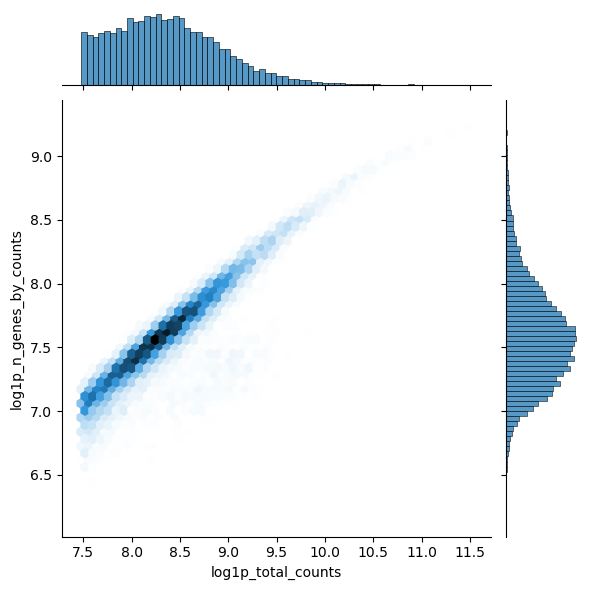

In [17]:
## plot correlation between log10 total counts and log10 number of unique genes
sns.jointplot(
    data=breast_pip.obs,
    x="log1p_total_counts",
    y="log1p_n_genes_by_counts",
    kind="hex",
)

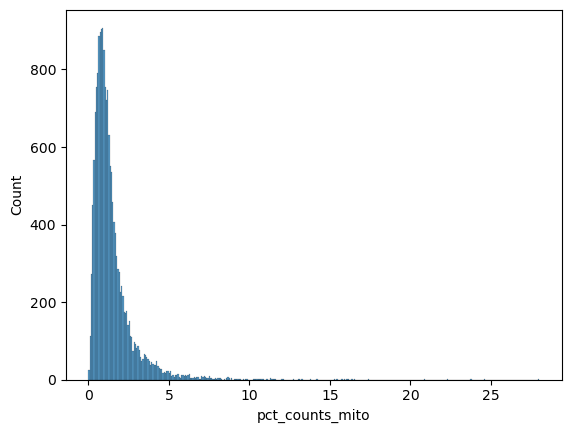

In [18]:
## plot histogram of % counts of mitochondrial gene
sns.histplot(breast_pip.obs["pct_counts_mito"])

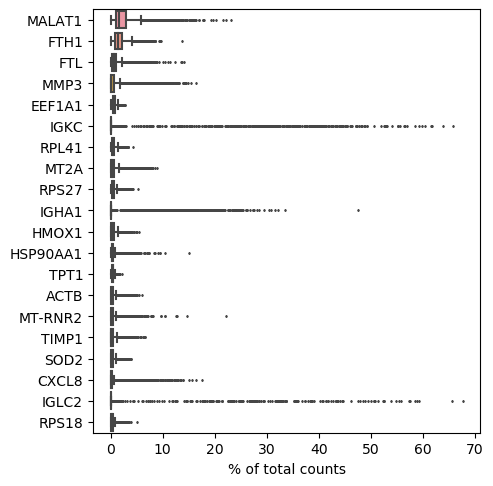

In [19]:
## breast_pip
sc.pl.highest_expr_genes(breast_pip, n_top=20)

#### Comparison

In [20]:
## number of cells in the dataset
ncell_10x = breast_10x.shape[0]
ncell_pip = breast_pip.shape[0]
print("# of cells in breast_10x data set is " + str(ncell_10x))
print("# of cells in breast_pip data set is " + str(ncell_pip))

# of cells in breast_10x data set is 792
# of cells in breast_pip data set is 17691


[Text(0, 0.5, '# of unique genes/cell'), Text(0.5, 0, 'Technology')]

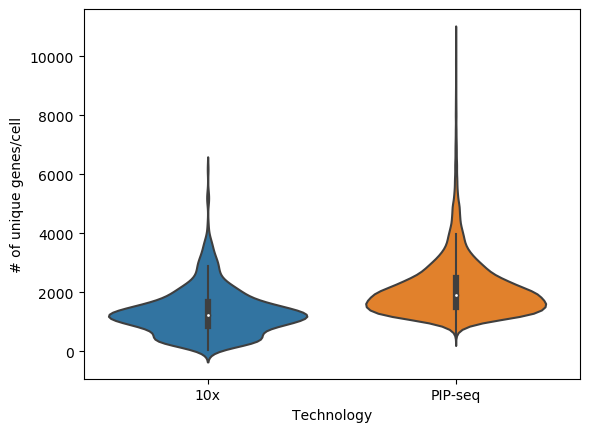

In [21]:
## number of unique genes/cell
df_ngenes = pd.DataFrame({"10x": breast_10x.obs["n_genes_by_counts"], "PIP-seq": breast_pip.obs["n_genes_by_counts"]})
df_ngenes = pd.melt(df_ngenes, value_vars = ["10x", "PIP-seq"], var_name = "Technology", value_name = "n_genes_by_counts")

plt_ngenes = sns.violinplot(data=df_ngenes, x="Technology", y="n_genes_by_counts")
plt_ngenes.set(
    xlabel = "Technology",
    ylabel = "# of unique genes/cell"
    )

[Text(0, 0.5, '# of total counts/cell'), Text(0.5, 0, 'Technology')]

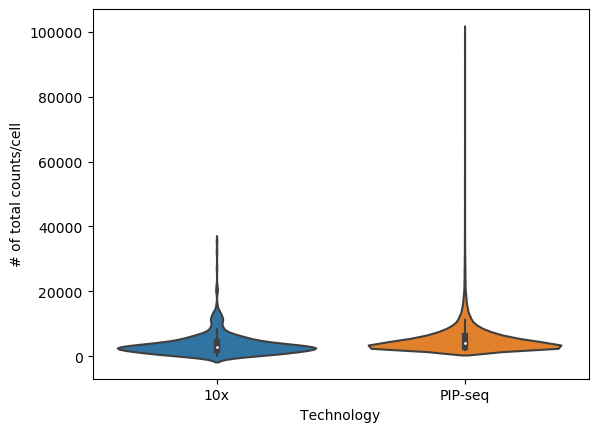

In [22]:
## number of total counts/cell
df_ncounts = pd.DataFrame({"10x": breast_10x.obs["total_counts"], "PIP-seq": breast_pip.obs["total_counts"]})
df_ncounts = pd.melt(df_ncounts, value_vars = ["10x", "PIP-seq"], var_name = "Technology", value_name = "total_counts")

plt_ncouts = sns.violinplot(data=df_ncounts, x="Technology", y="total_counts")
plt_ncouts.set(
    xlabel = "Technology",
    ylabel = "# of total counts/cell"
    )

[Text(0, 0.5, '% counts of mitochondrial genes'), Text(0.5, 0, 'Technology')]

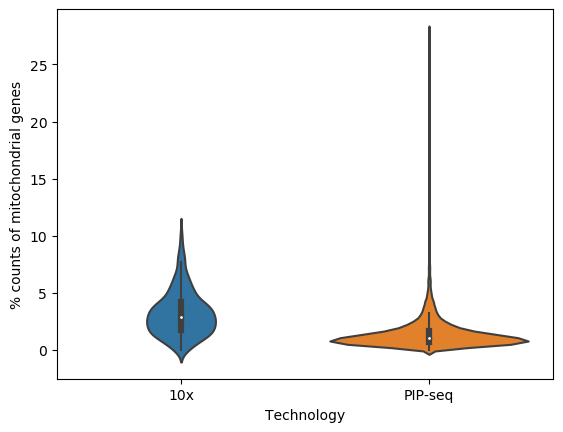

In [23]:
## % counts mitochondrial/cell
df_pct_mt = pd.DataFrame({"10x": breast_10x.obs["pct_counts_mito"], "PIP-seq": breast_pip.obs["pct_counts_mito"]})
df_pct_mt = pd.melt(df_pct_mt, value_vars = ["10x", "PIP-seq"], var_name = "Technology", value_name = "pct_counts_mito")

plt_pct_mt = sns.violinplot(data=df_pct_mt, x="Technology", y="pct_counts_mito")
plt_pct_mt.set(
    xlabel = "Technology",
    ylabel = "% counts of mitochondrial genes"
    )

### Preprocess

In [24]:
## normalization
sc.pp.normalize_total(breast_10x, target_sum=1e4)
sc.pp.normalize_total(breast_pip, target_sum=1e4)

In [25]:
## log10 transform
sc.pp.log1p(breast_10x)
sc.pp.log1p(breast_pip)

In [26]:
## set the threshhold value for the minimum number cells that genes must be expressed
gThresh = 5
## remove genes that are expressed in less than gThresh cells
sc.pp.filter_genes(breast_10x, min_cells=gThresh)
sc.pp.filter_genes(breast_pip, min_cells=gThresh)

/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [27]:
## define a function to remove mitochondrial and ribosomal genes
def mito_rib_genes(adQ):
    adata = adQ.copy()
    # define the genes that we want to ignore. these are boolean arrays
    mito_genes = adata.var_names.str.startswith('MT-')
    ribo_genes = adata.var_names.str.startswith(("RPl","RPS"))
    malat_gene = adata.var_names.str.startswith("MALAT1")
    # merge them such that if a gene meets any of these critera, then the resulting entry is True
    remove = np.add(mito_genes, ribo_genes)
    remove = np.add(remove, malat_gene)
    #  invert this to keep only the genes that do not pass these criteria
    keep = np.invert(remove)
    # show the number of genes we are removing
    print(len(keep) - np.count_nonzero(keep))
    # subset adata to remove the genes we specified above
    adata = adata[:,keep].copy()
    return adata

## define a function to check if mitochondrial and ribosomal genes were properly removed
## output True if there is any genes that needed to be removed (False = good)
def checkremoval_mito_rib_genes(adQ):
  adata = adQ.copy()
  # define the genes that we want to ignore. these are boolean arrays
  mito_genes = adata.var_names.str.startswith('MT-')
  ribo_genes = adata.var_names.str.startswith(("RPl","RPS"))
  malat_gene = adata.var_names.str.startswith("MALAT1")
  # merge them such that if a gene meets any of these critera, then the resulting entry is True
  remove = np.add(mito_genes, ribo_genes)
  remove = np.add(remove, malat_gene)
  print(True in remove)

In [28]:
## remove mitochondrial and ribosomal genes
breast_10x = mito_rib_genes(breast_10x)
checkremoval_mito_rib_genes(breast_10x)

breast_pip = mito_rib_genes(breast_pip)
checkremoval_mito_rib_genes(breast_pip)

57
False
373
False


### Analysis

#### Identify HVG

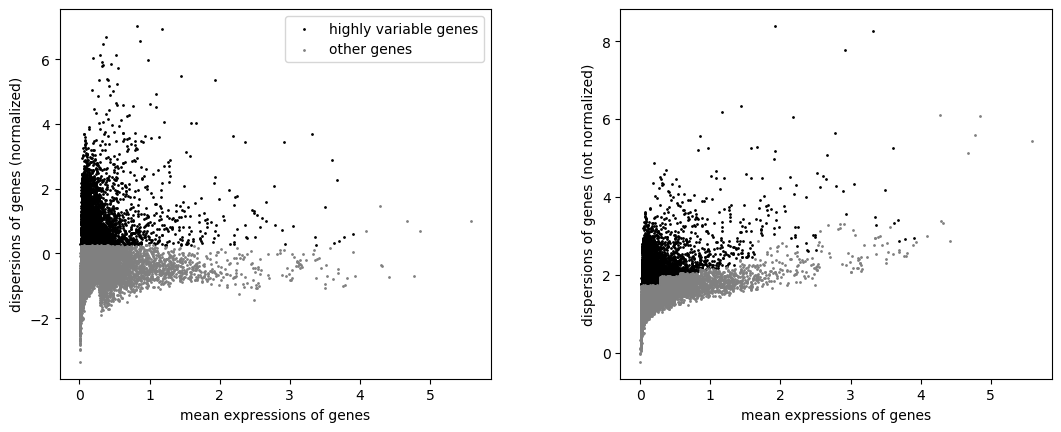

In [29]:
## breast_10x
sc.pp.highly_variable_genes(breast_10x, min_mean=0.0125, max_mean=4, min_disp=0.25)
sc.pl.highly_variable_genes(breast_10x)

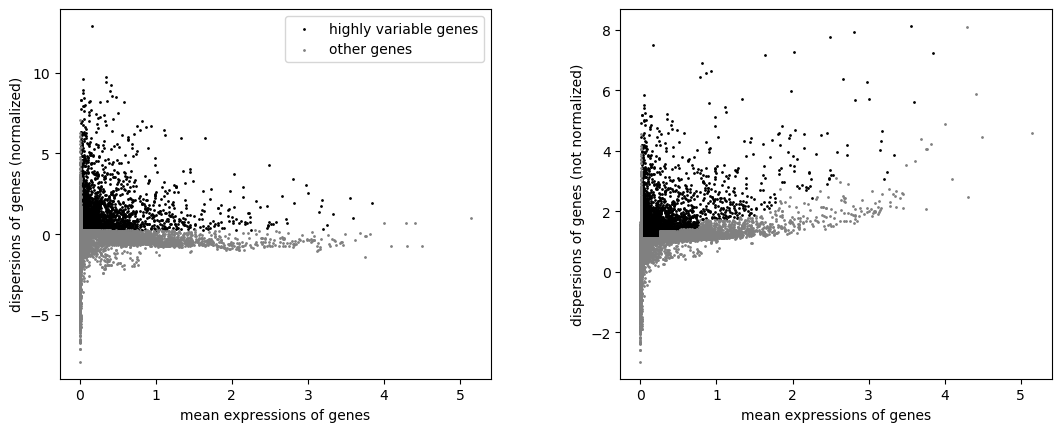

In [30]:
## breast_pip
sc.pp.highly_variable_genes(breast_pip, min_mean=0.0125, max_mean=4, min_disp=0.25)
sc.pl.highly_variable_genes(breast_pip)

#### Scale

In [31]:
## scale gene exprression
sc.pp.scale(breast_10x)
sc.pp.scale(breast_pip)

#### Breast 10X Chromium dataset

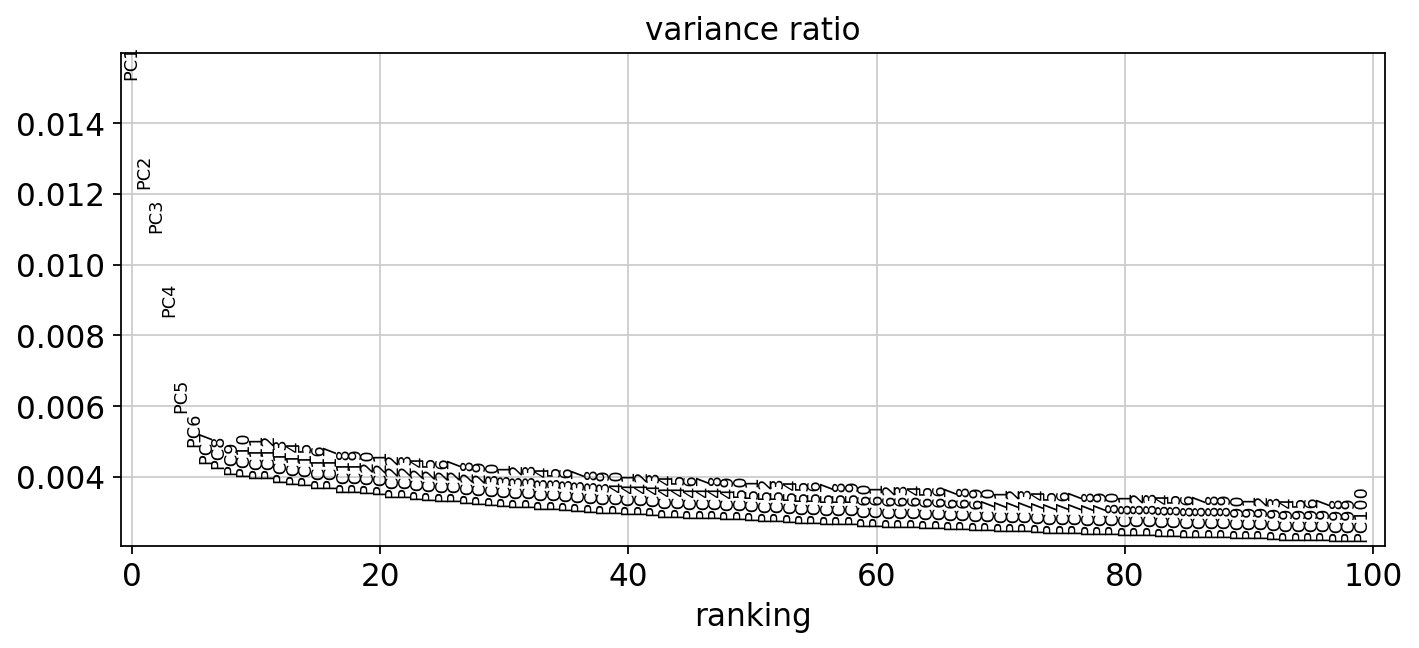

In [32]:
## pca
sc.tl.pca(breast_10x, n_comps = 100, random_state = seed)
sc.set_figure_params(figsize="10, 4")
sc.pl.pca_variance_ratio(breast_10x, 100)
sc.set_figure_params()

In [33]:
## knearest neighbors and UMAP
npcs = 20
nknns = 15
sc.pp.neighbors(breast_10x, n_neighbors = nknns, n_pcs = npcs)
sc.tl.umap(breast_10x, 1, random_state = seed)

In [34]:
## resolve duplicated var_names to produce dot plots
breast_10x.var_names_make_unique()

In [35]:
breast_marker_genes_dict_10x = {
    "Fibroblast": ["DCN", "MMP2", "PDPN"],
    #"LEP1": ["ALDH1A3", "LTF", "PROM1", "ESR1", "PGR"],
    "LEP1": ["ALDH1A3", "LTF", "PROM1", "ESR1"],
    #"LEP2": ["KRT19", "ELF3", "MUC1", "AGR2", "ANKRD30A", "TFF3", "ESR1", "PGR"],
    "LEP2": ["KRT19", "ELF3", "MUC1", "AGR2", "ANKRD30A", "TFF3", "ESR1"],
    "Myoepithelial": ["KRT14", "KRT17", "TP63", "ACTA2"],
    #"Macrophage": ["CD14", "CD16", "CD64", "CD68", "CD71", "CCL3"],
    "Macrophage": ["CD14", "CD68", "TFRC", "CCL3"],
    #"Dendritic cell": ["LY75", "CCR7"],
    "Dendritic cell": ["CCR7"],
    "Vascular accessory": ["RGS5"],
    "Endothelial": ["ANGPT2", "CDH5", "CLDN5"],
    "Lymphocyte": ["CD52", "CXCR4", "CD3D", "CD8A", "PTPRC"]
}

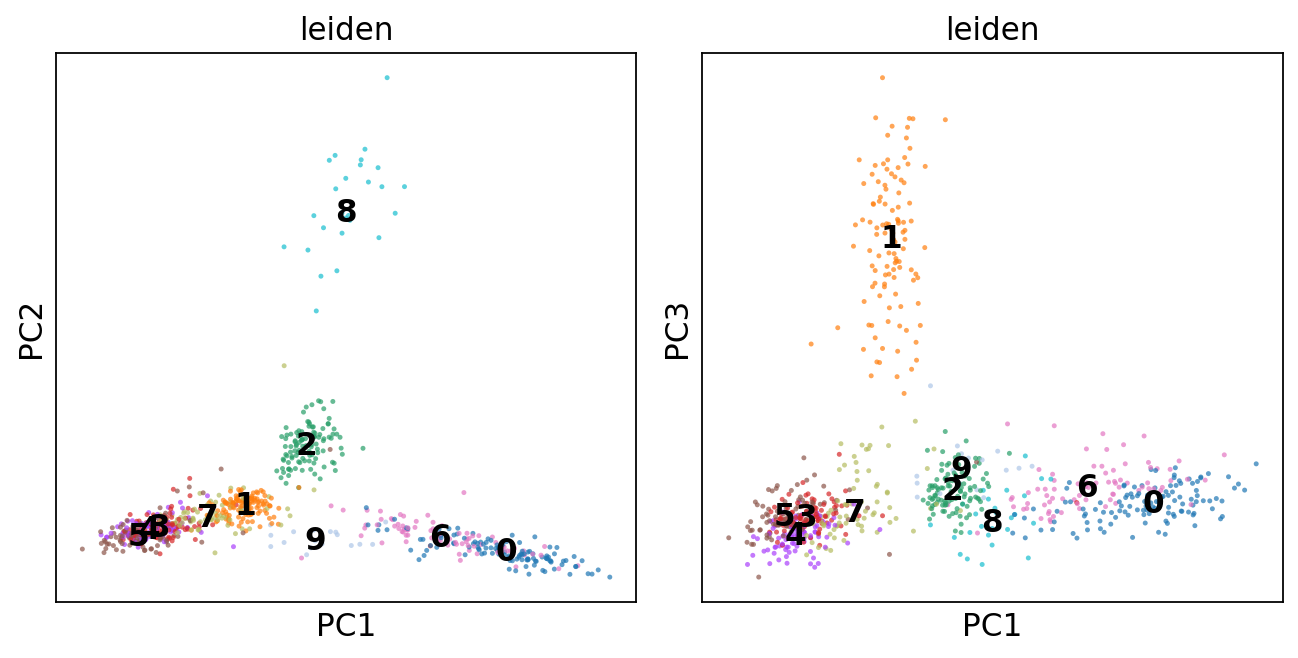

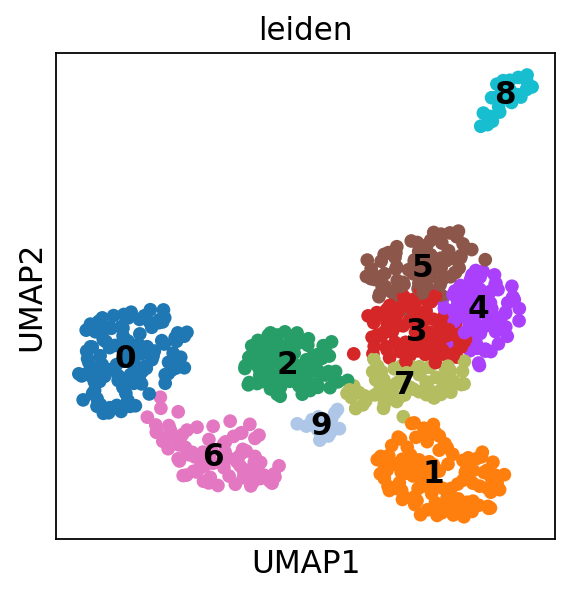

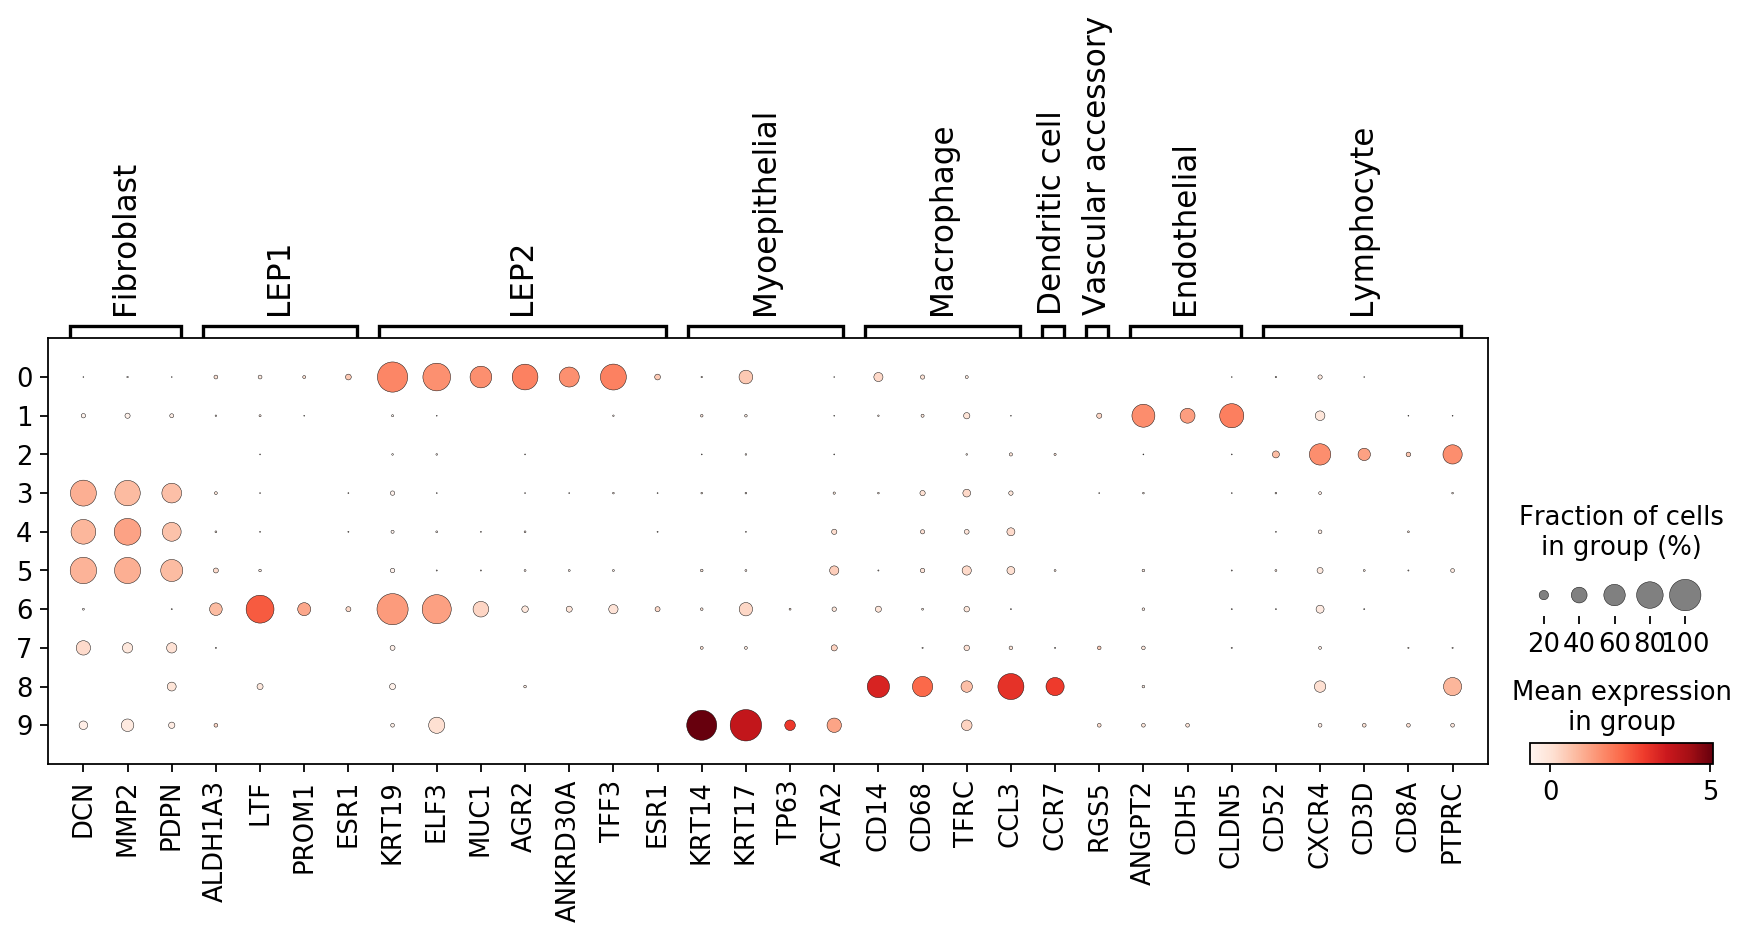

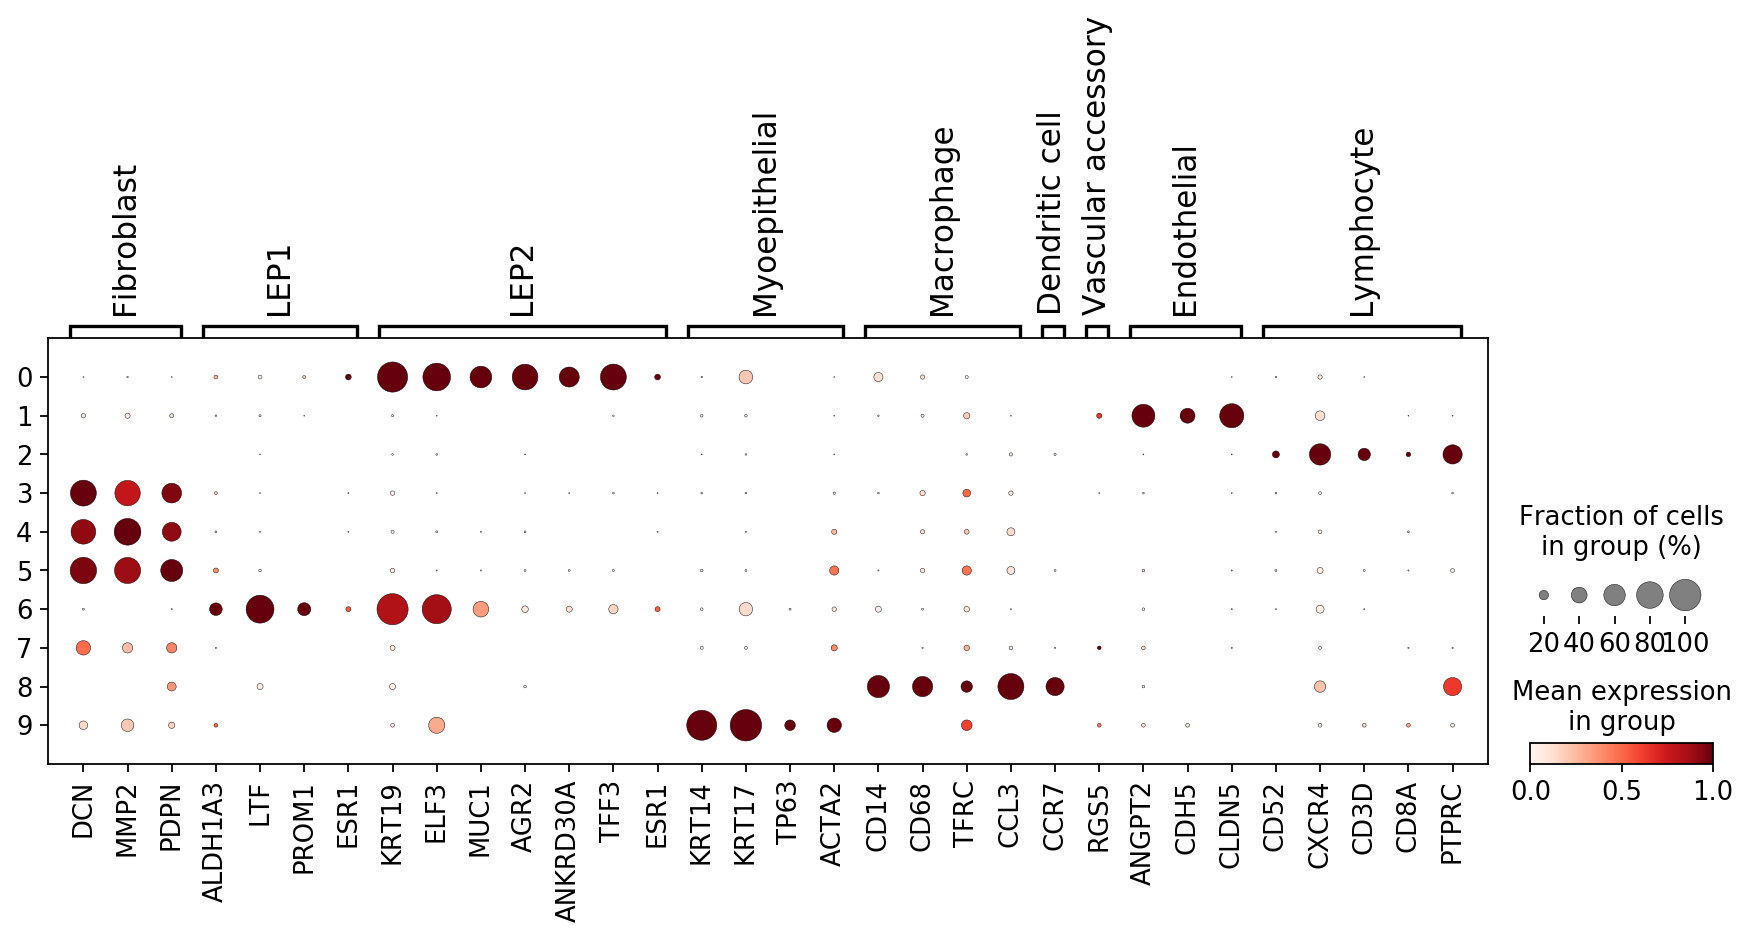

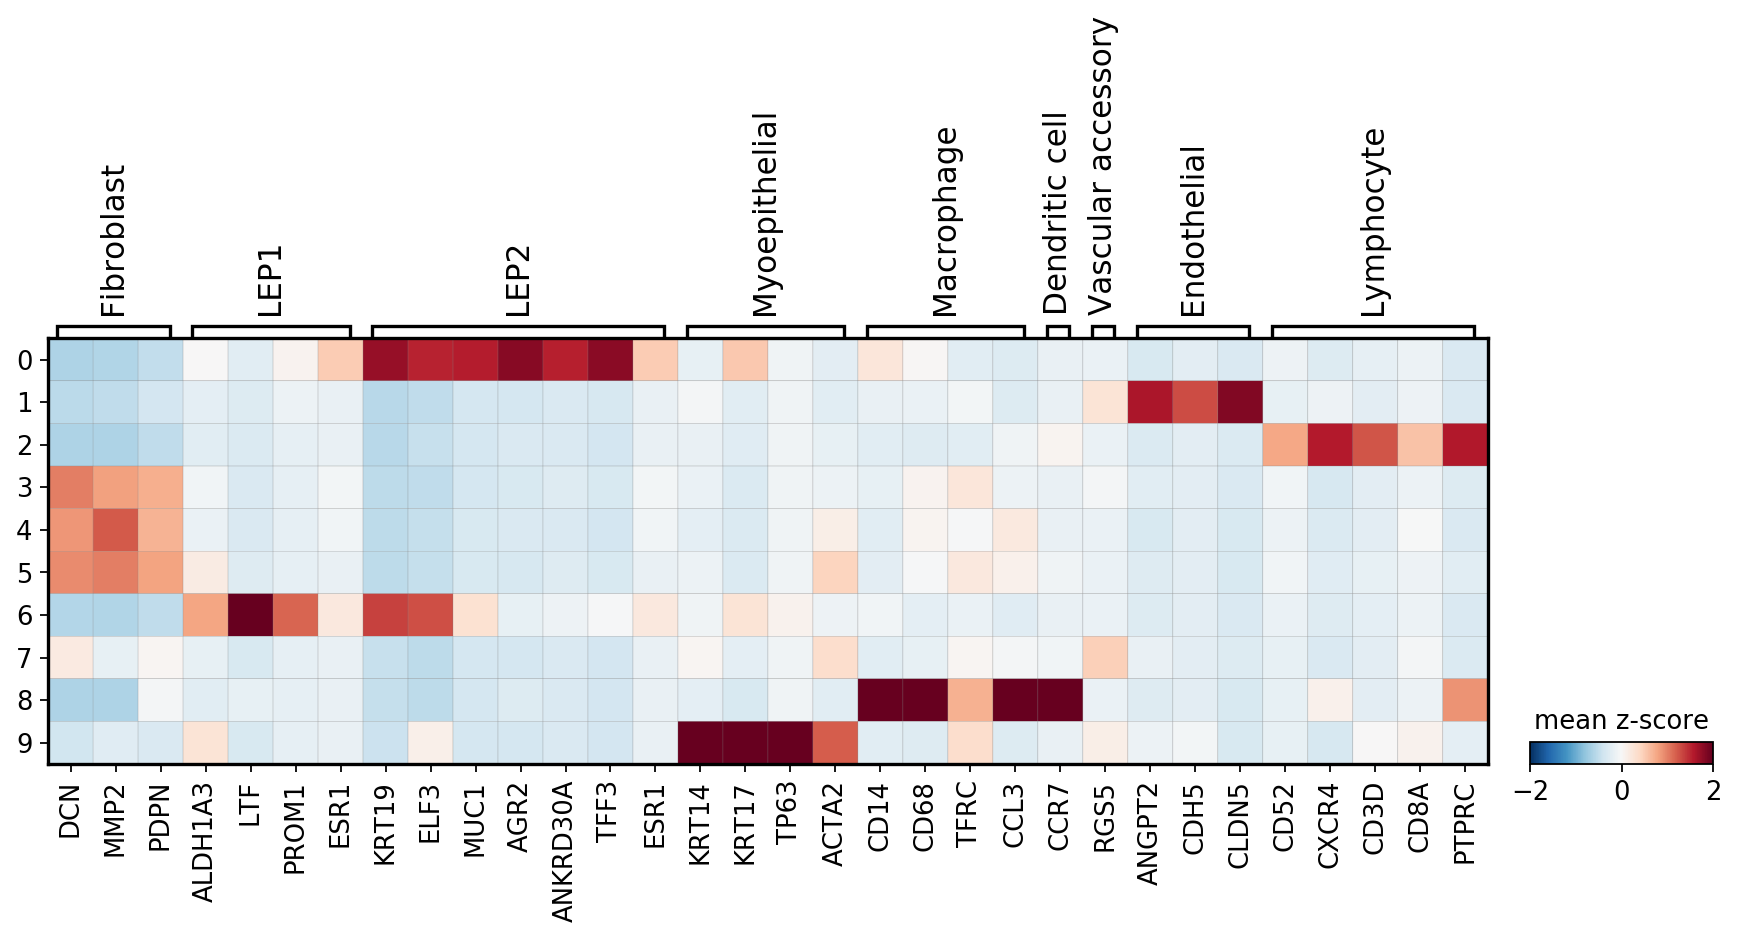

In [37]:
## leiden clustering (leiden resolution and the number of clusters is randomly chosen as we do not know the number of distinct cell types in the data set)
sc.tl.leiden(breast_10x,1)

## plot leiden clusters on PC1 vs. PC2
fig, axs = plt.subplots(1,2, figsize=(8,4), constrained_layout=True)
sc.pl.pca(breast_10x, color=["leiden"], alpha=.7, s=20, components="1,2",legend_loc='on data', ax=axs[0], show=False)
sc.pl.pca(breast_10x, color=["leiden"], alpha=.7, s=20, components="1,3",legend_loc='on data', ax=axs[1], show=False)

## plot leiden clusters on UMAP
sc.pl.umap(breast_10x, color=['leiden'], legend_loc="on data")

## dot plot to assign cell types to clusters
sc.pl.dotplot(breast_10x, breast_marker_genes_dict_10x, 'leiden', use_raw = False)
sc.pl.dotplot(breast_10x, breast_marker_genes_dict_10x, 'leiden', use_raw = False, standard_scale='var')

## matrix plot to assign cell types to clusters
breast_10x.layers["scaled"] = sc.pp.scale(breast_10x, copy=True).X
sc.pl.matrixplot(breast_10x, breast_marker_genes_dict_10x, 'leiden', dendrogram=False, colorbar_title='mean z-score', layer='scaled', vmin=-2, vmax=2, cmap='RdBu_r')

In [38]:
## assign cell types
cluster2annotation_10x = {
    "0": "LEP2",
    "1": "Endothelial",
    "2": "Lymphocyte",
    "3": "Fibroblast",
    "4": "Fibroblast",
    "5": "Fibroblast",
    "6": "LEP1",
    "7": "Unknown 1",
    "8": "Macrophage",
    "9": "Myoepithelial"
}

breast_10x.obs['celltype'] = breast_10x.obs['leiden'].map(cluster2annotation_10x).astype('category')

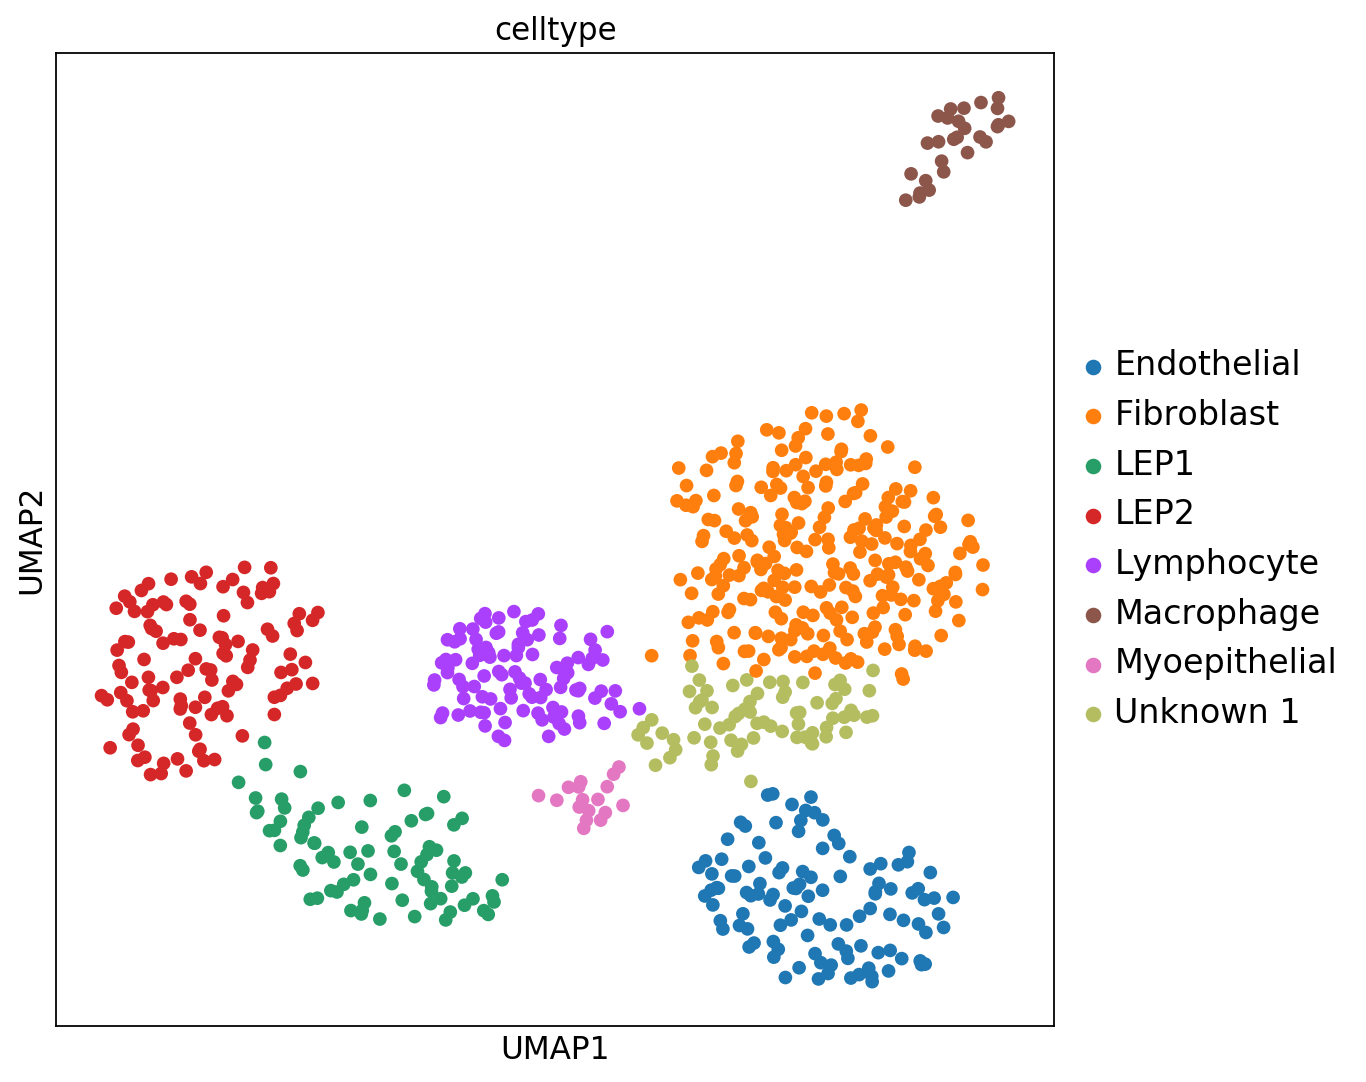

In [39]:
# plot UMAP based on annotated cell types
sc.set_figure_params(figsize="8, 8")
sc.pl.umap(breast_10x, color='celltype', legend_loc='right margin', legend_fontsize=15, legend_fontoutline=0)
sc.set_figure_params()

In [40]:
## run Wilcoxon rank-sum test
sc.tl.rank_genes_groups(breast_10x, 'celltype', method='wilcoxon', key_added = 'wilcoxon', random_state = seed, use_raw = False)

/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:420: 

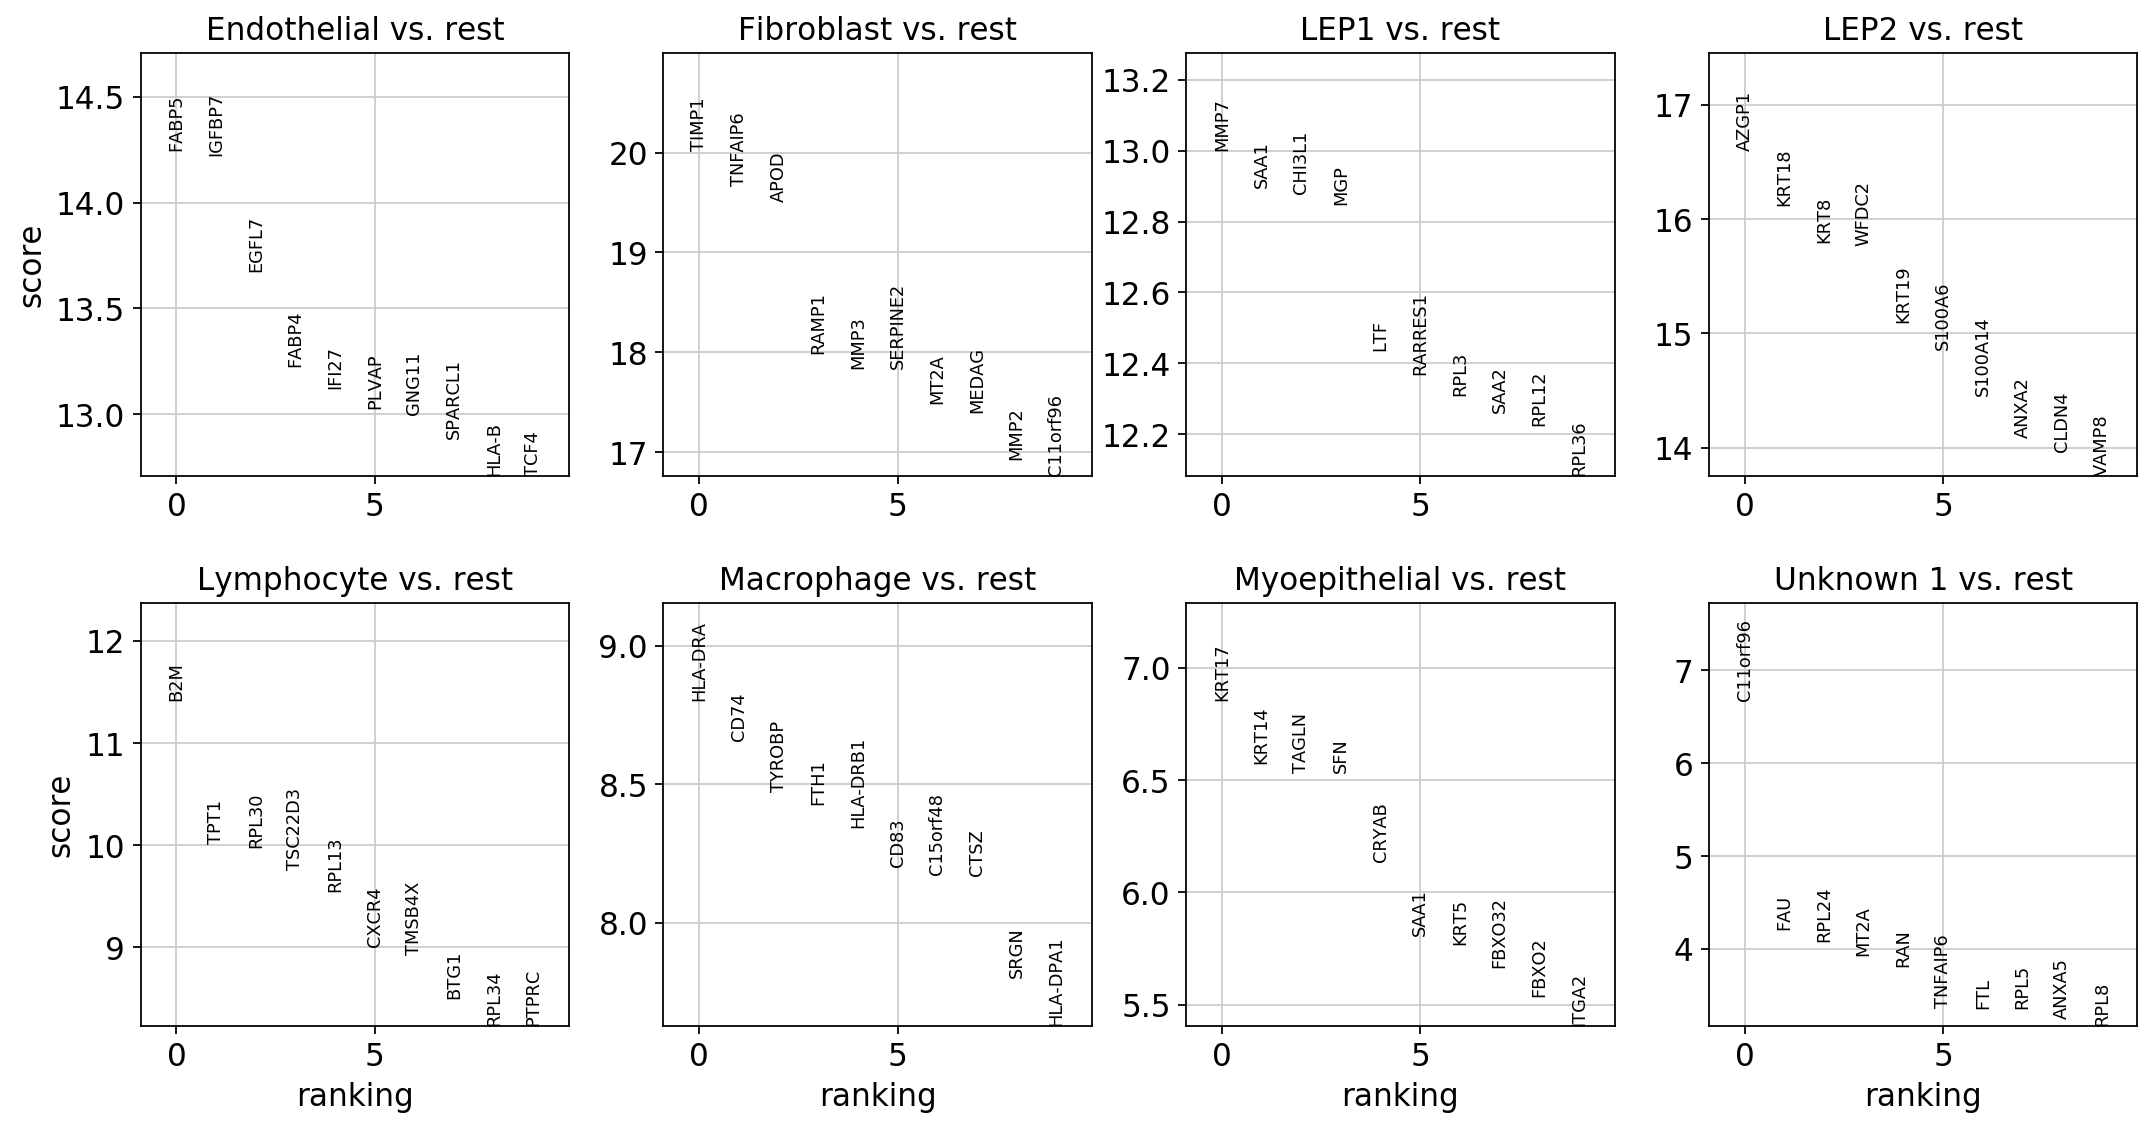

In [41]:
# plot top 10 differentially expressed for each cluster vs. rest
sc.pl.rank_genes_groups(breast_10x, n_genes = 10, sharey = False, key = 'wilcoxon')

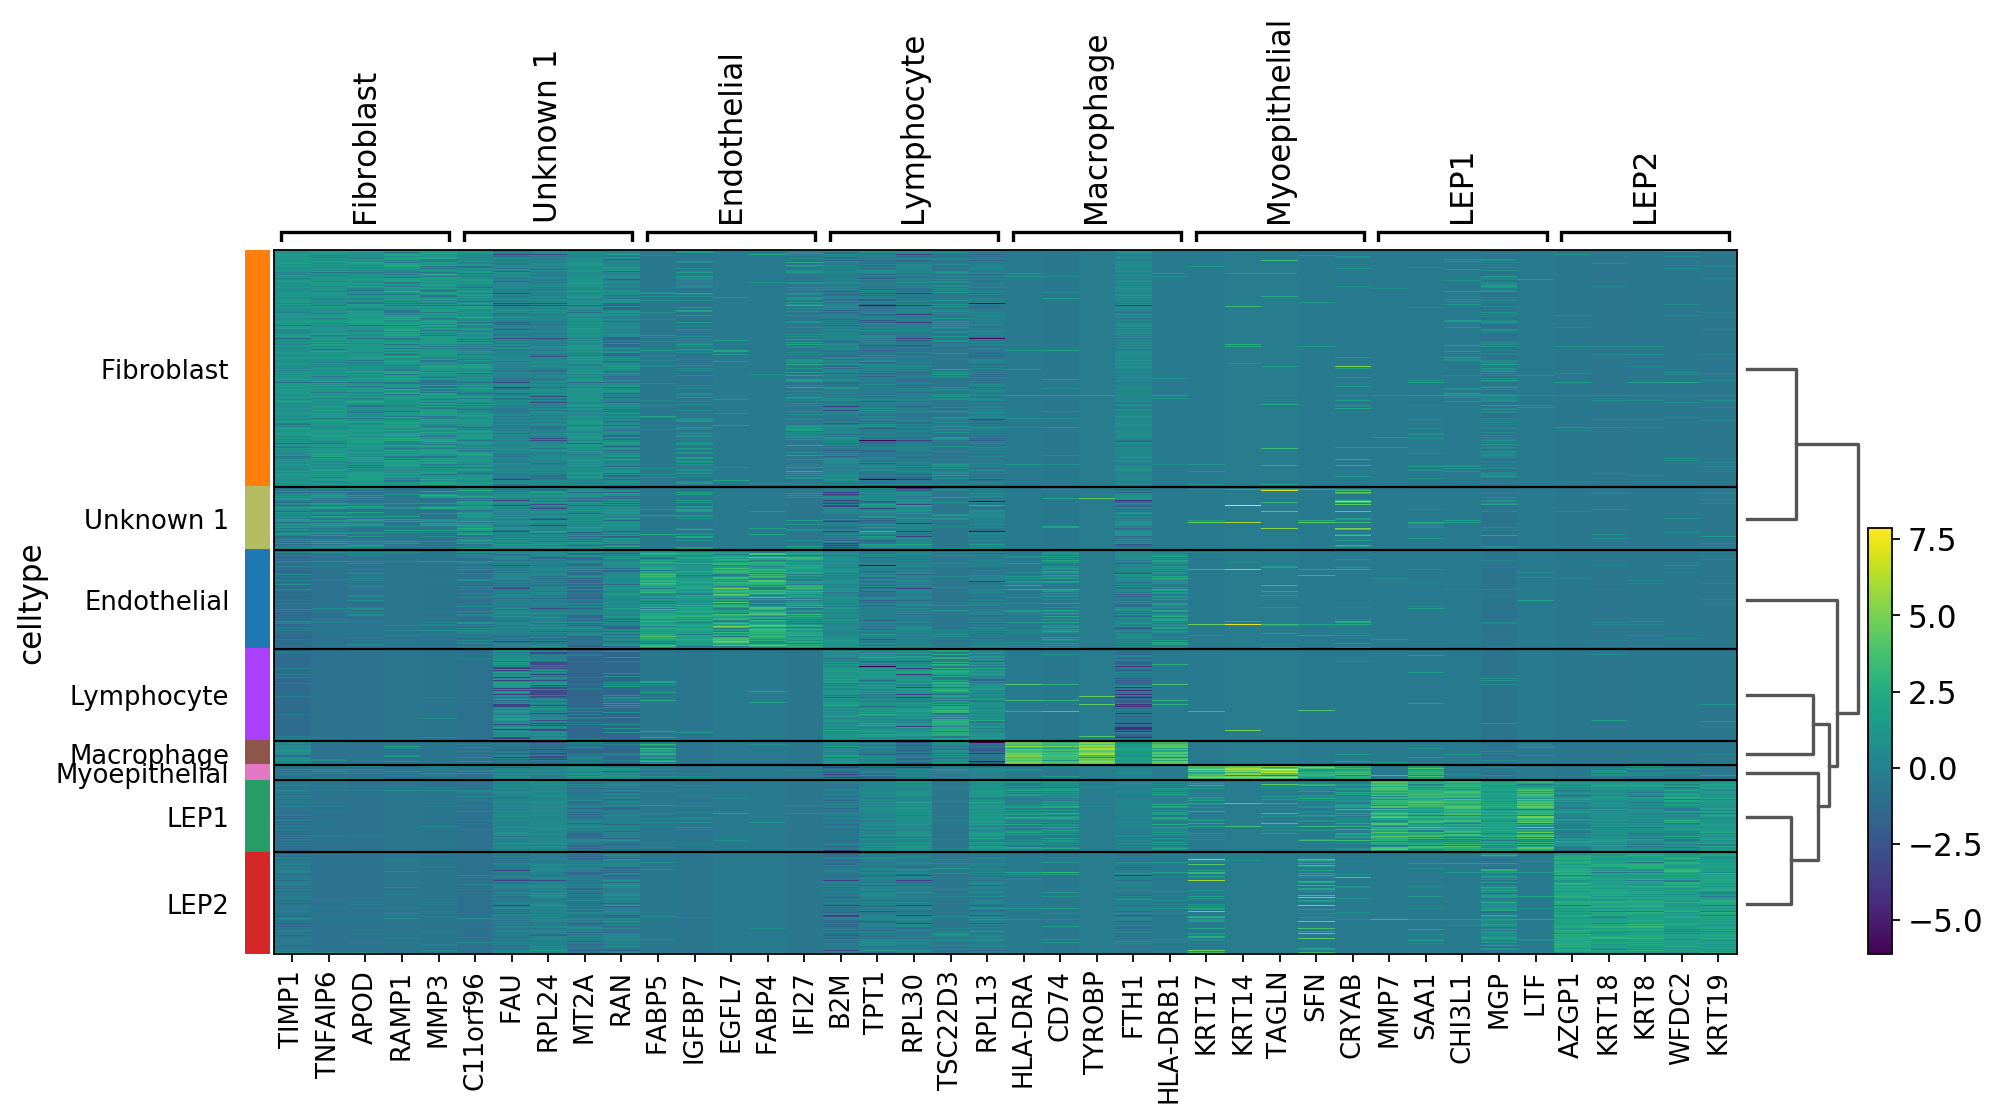

In [42]:
# visualize top differentially expressed genes for each cluster as a heatmap
sc.pl.rank_genes_groups_heatmap(breast_10x, n_genes = 5, key = 'wilcoxon', groupby = 'celltype', show_gene_labels = True, use_raw = False)

#### Breast PIP-seq data set

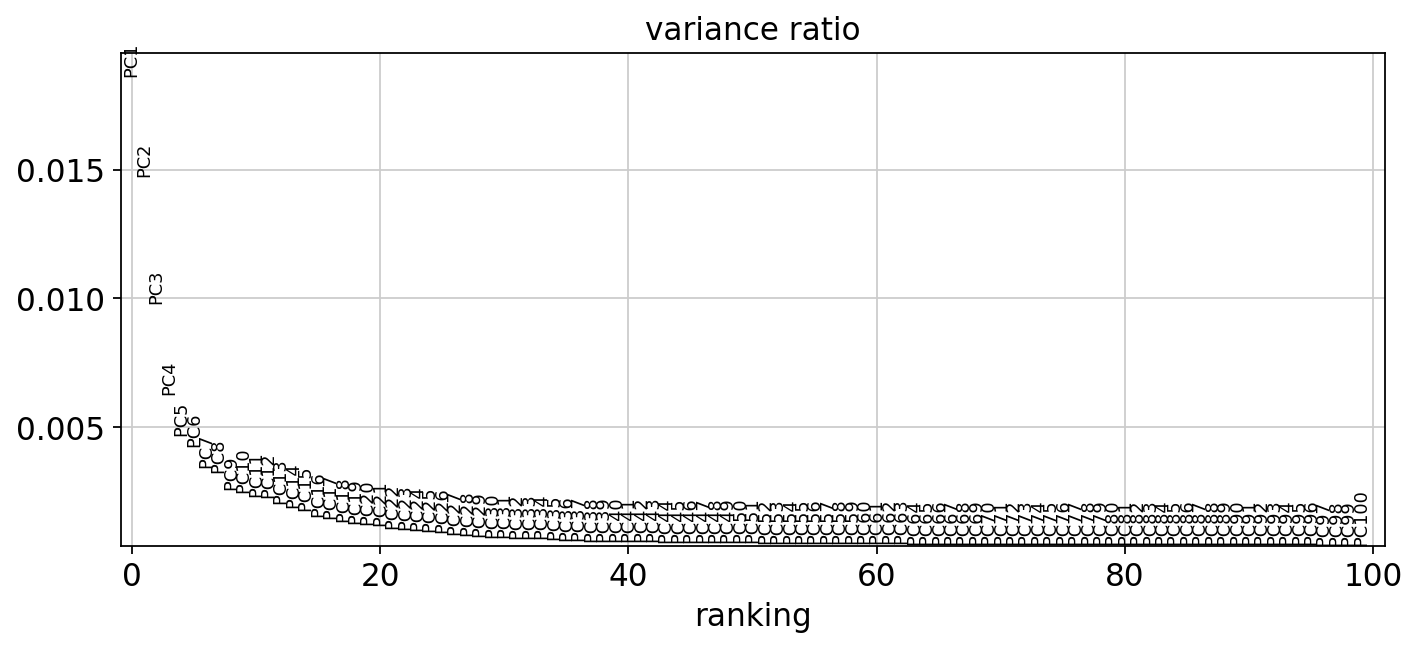

In [43]:
## pca
sc.tl.pca(breast_pip, n_comps = 100, random_state = seed)
sc.set_figure_params(figsize="10, 4")
sc.pl.pca_variance_ratio(breast_pip, 100)
sc.set_figure_params()

In [44]:
## knearest neighbors and UMAP
npcs = 20
nknns = 15
sc.pp.neighbors(breast_pip, n_neighbors = nknns, n_pcs = npcs)
sc.tl.umap(breast_pip, .5, random_state = seed)

In [45]:
## resolve duplicated var_names to produce dot plots
breast_pip.var_names_make_unique()

In [46]:
breast_marker_genes_dict_pip = {
    "Fibroblast": ["DCN", "MMP2", "PDPN"],
    "LEP1": ["ALDH1A3", "LTF", "PROM1", "ESR1", "PGR"],
    "LEP2": ["KRT19", "ELF3", "MUC1", "AGR2", "ANKRD30A", "TFF3", "ESR1", "PGR"],
    "Myoepithelial": ["KRT14", "KRT17", "TP63", "ACTA2"],
    #"Macrophage": ["CD14", "CD16", "CD64", "CD68", "CD71", "CCL3"],
    "Macrophage": ["CD14", "FCGR3A", "FCGR3B", "FCGR1A", "FCGR1B", "CD68", "TFRC", "CCL3"],
    "Dendritic cell": ["LY75", "CCR7"],
    "Vascular accessory": ["RGS5"],
    "Endothelial": ["ANGPT2", "CDH5", "CLDN5"],
    "Lymphocyte": ["CD52", "CXCR4", "CD3D", "CD8A", "PTPRC"]
}

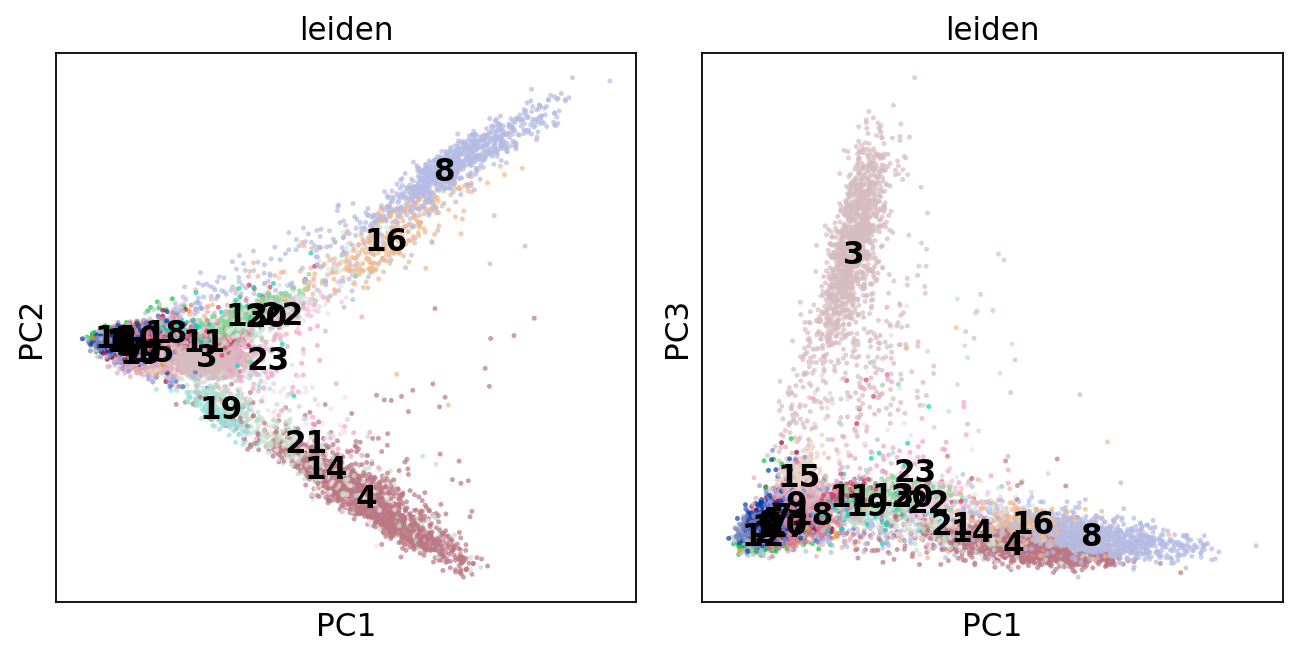

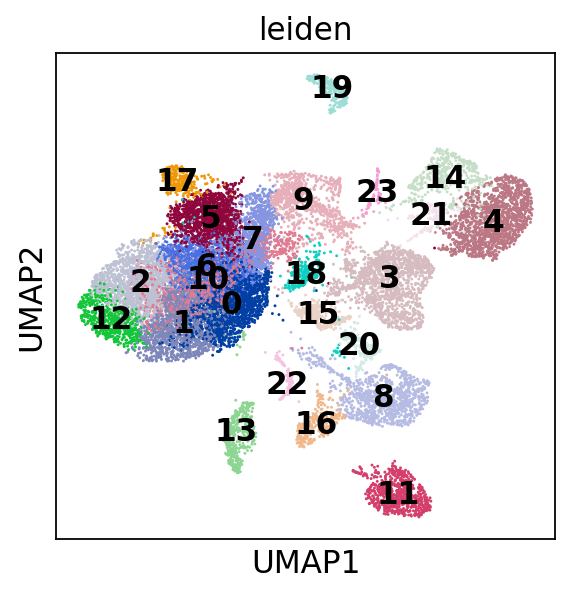

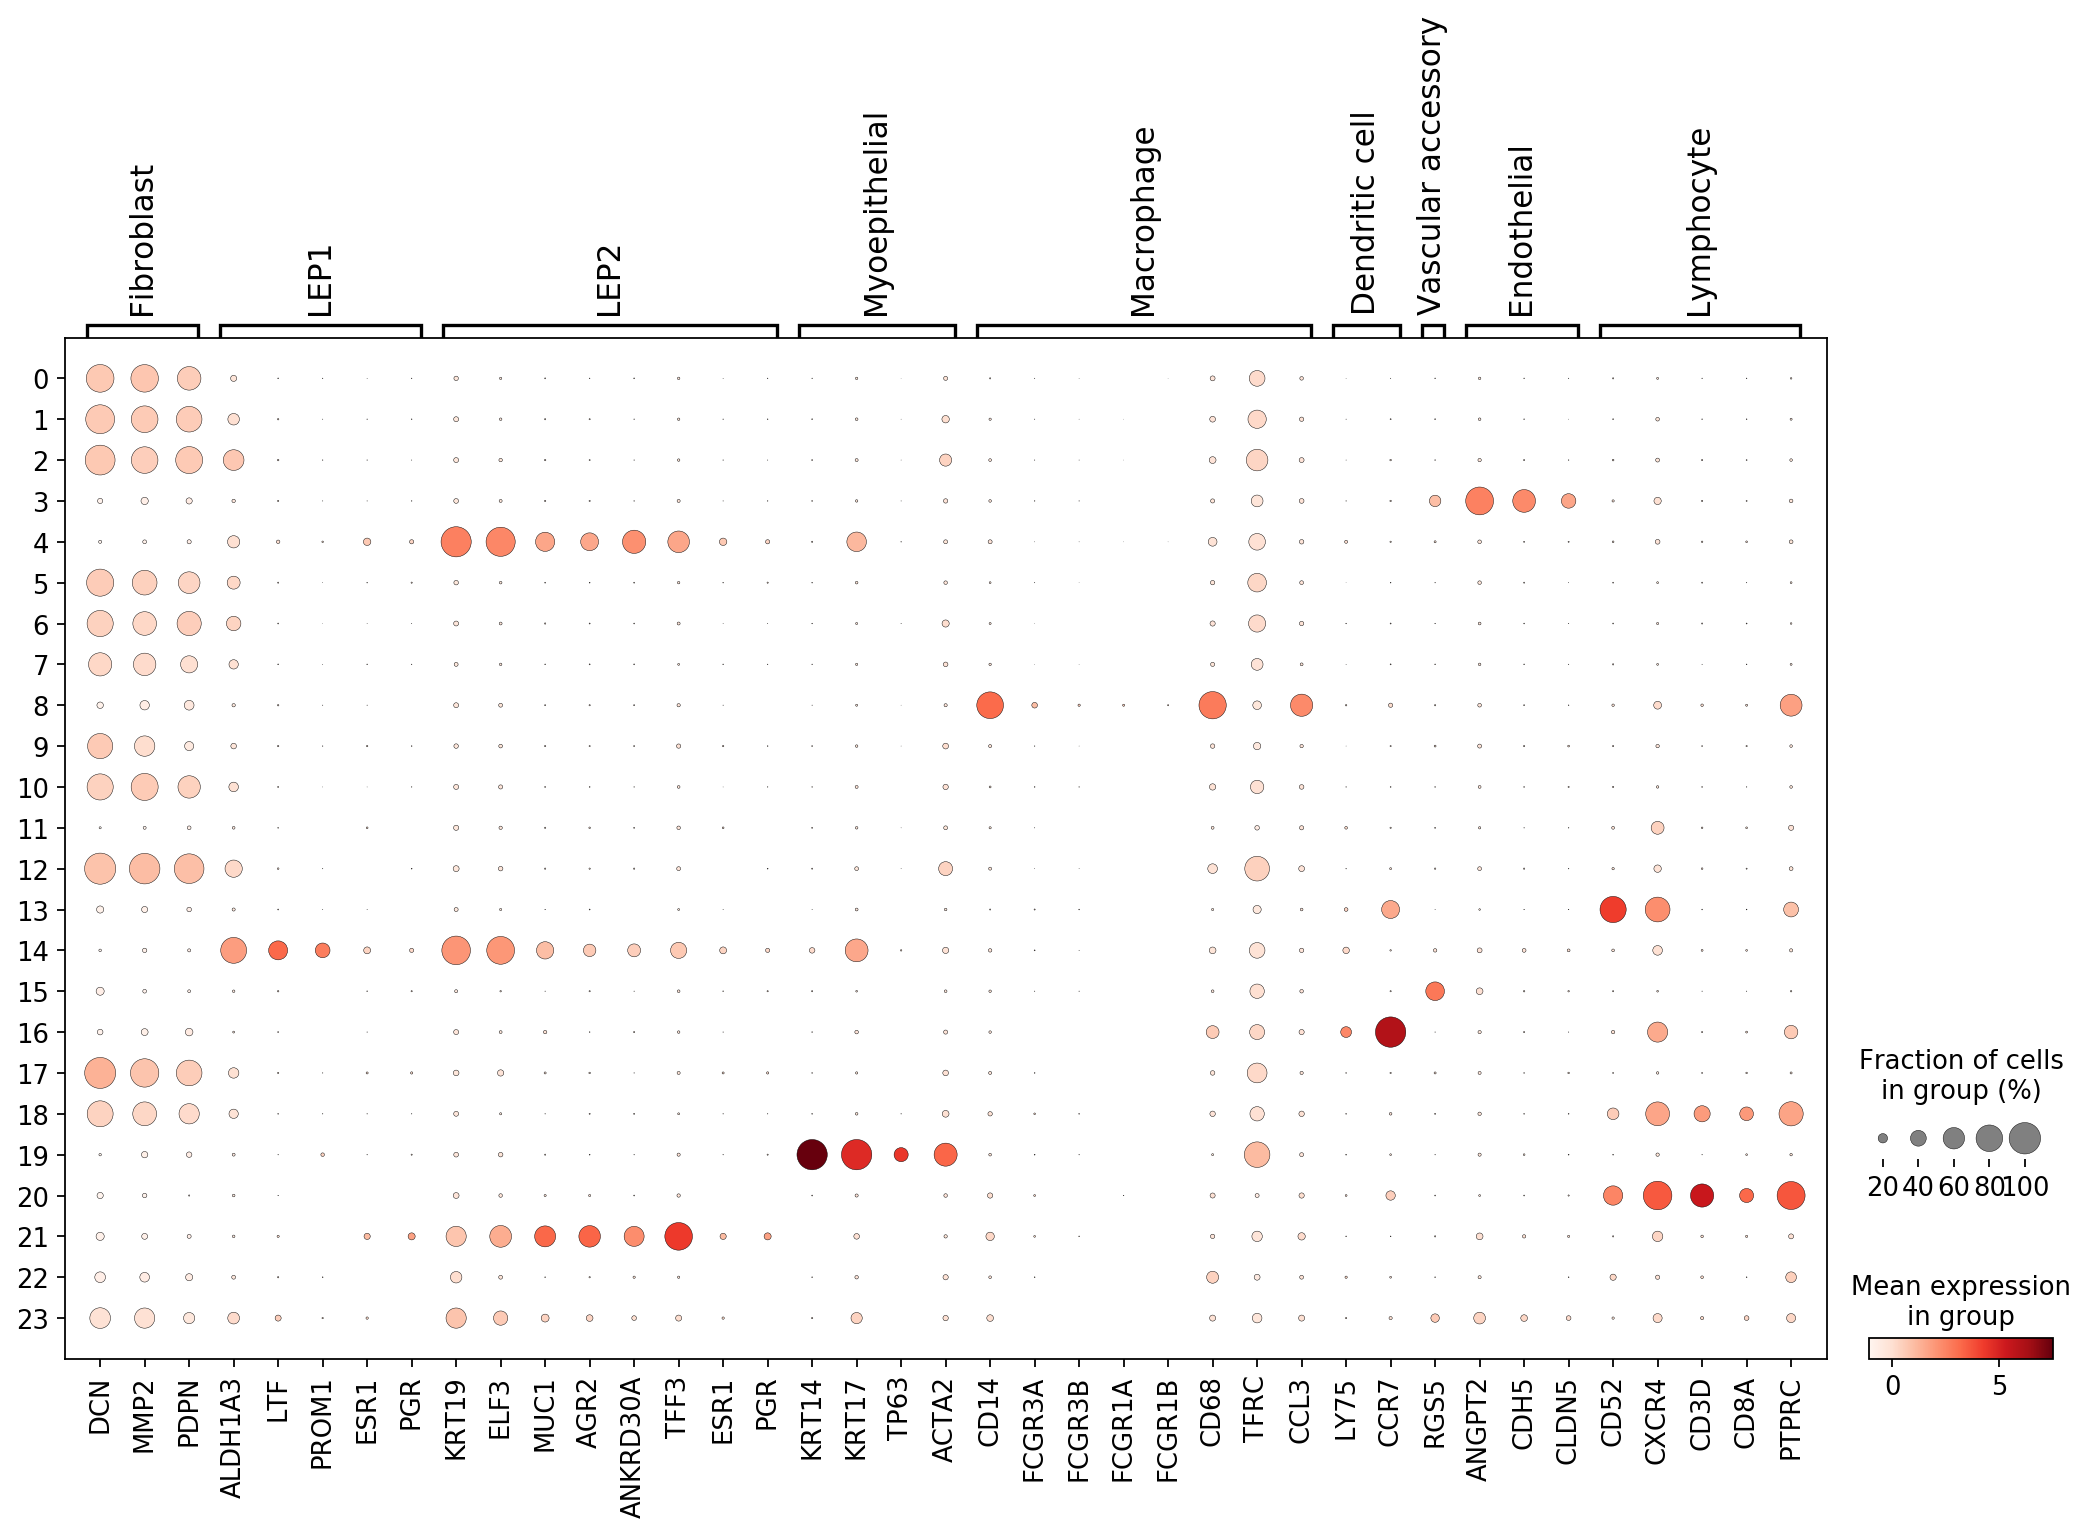

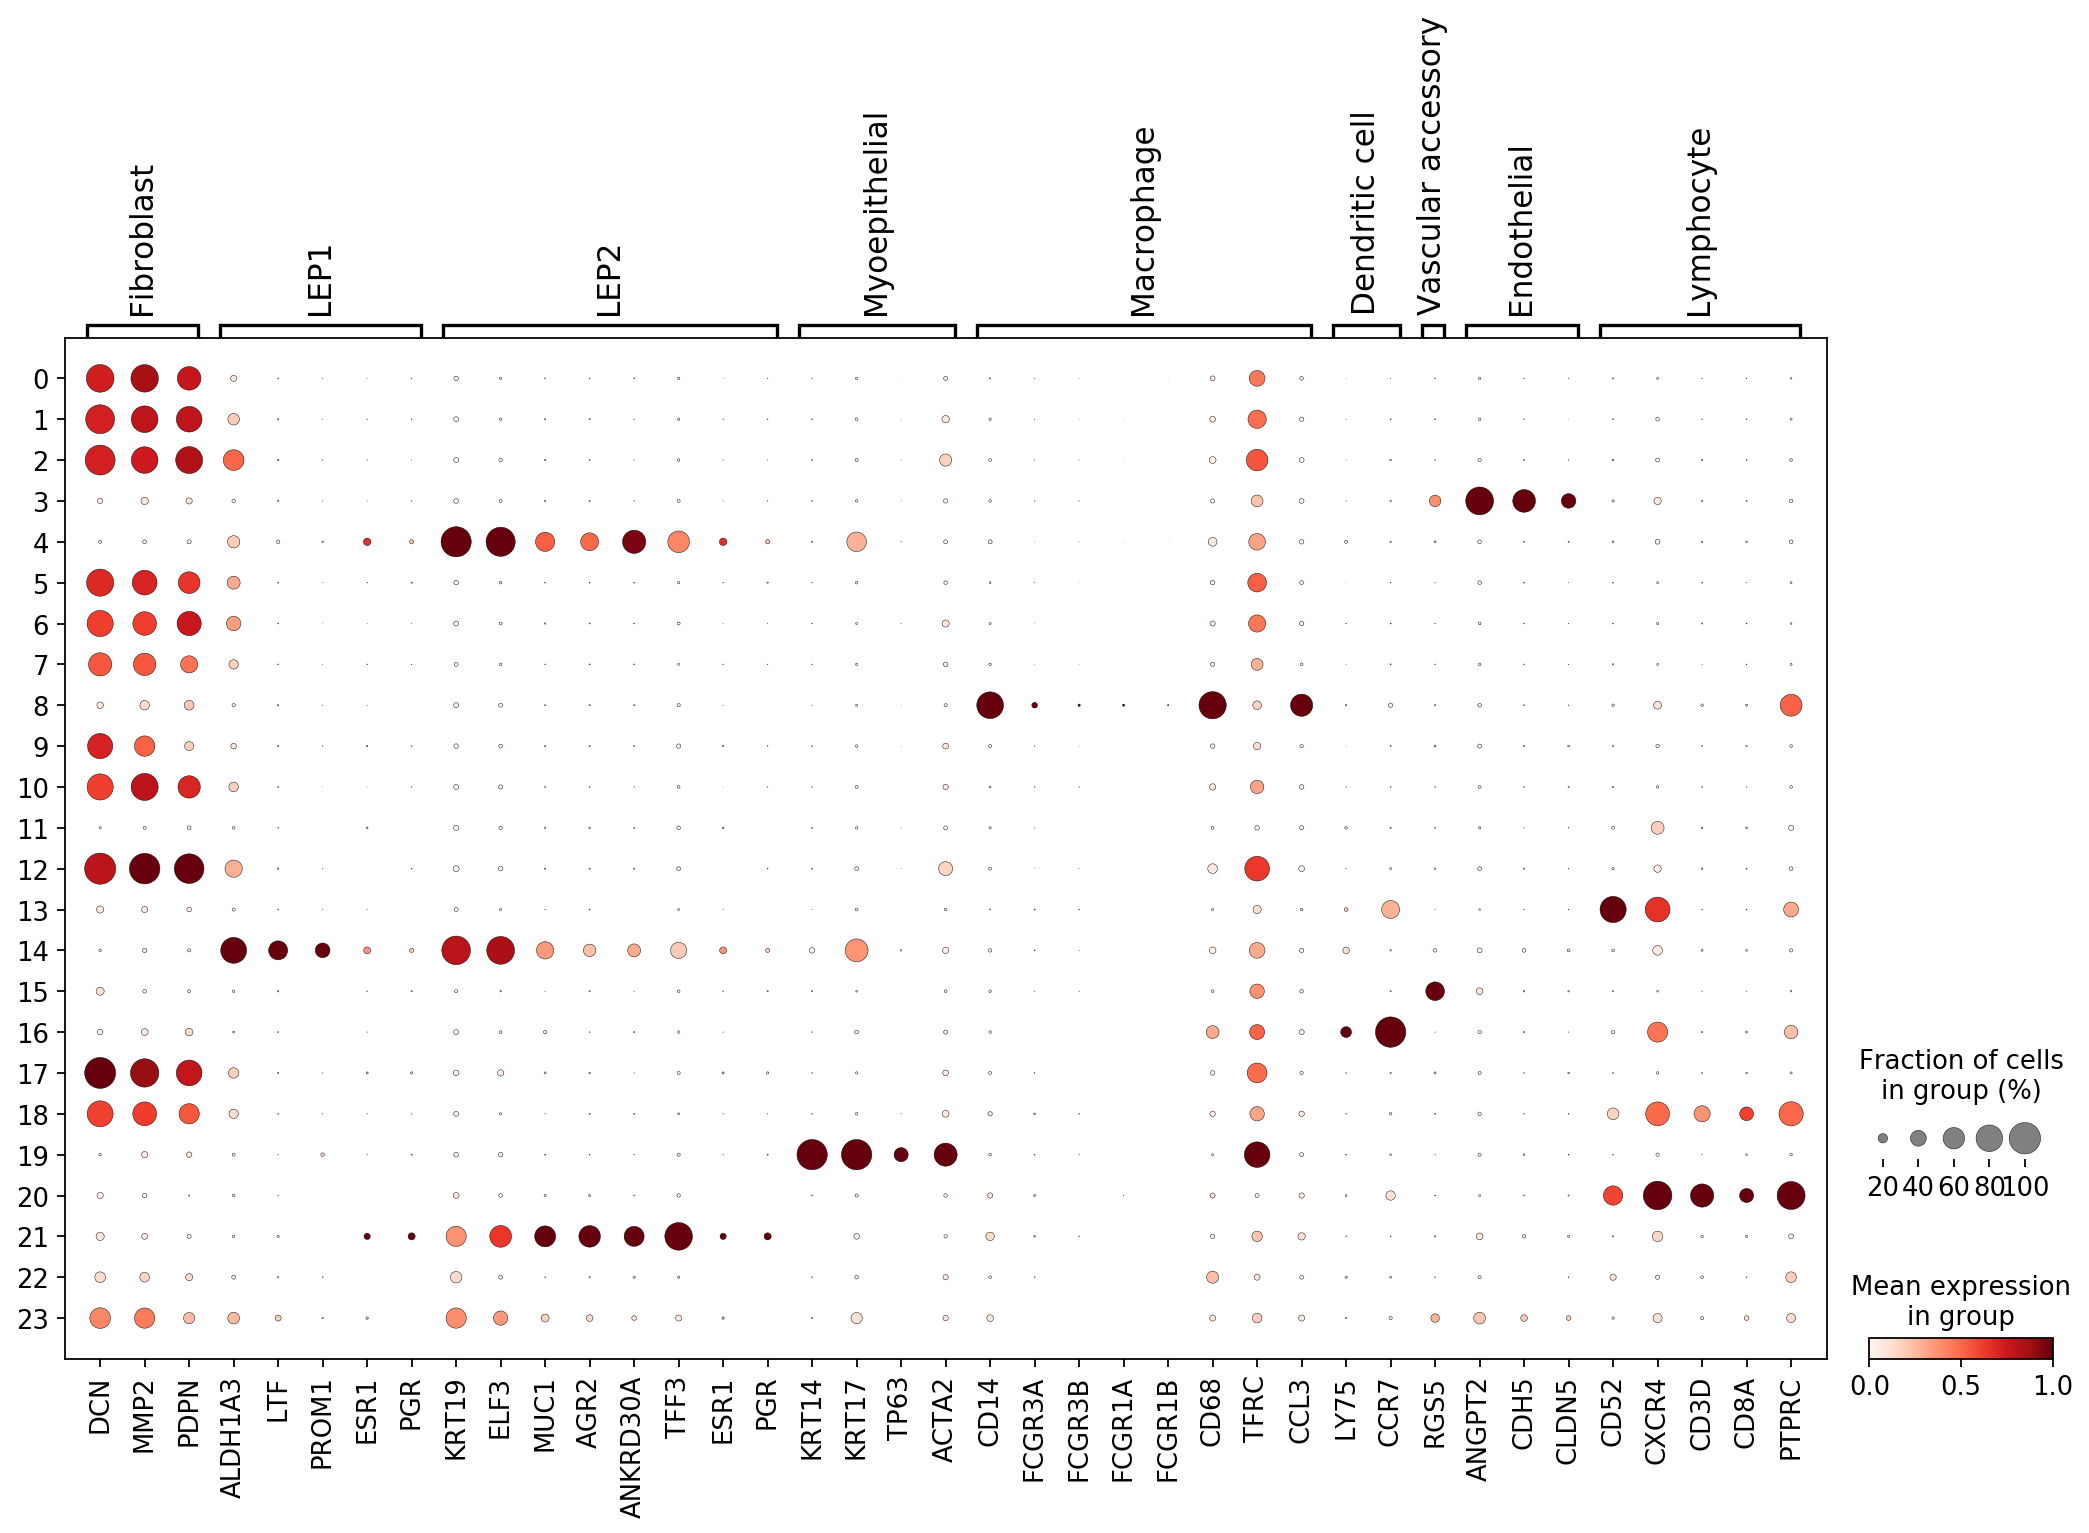

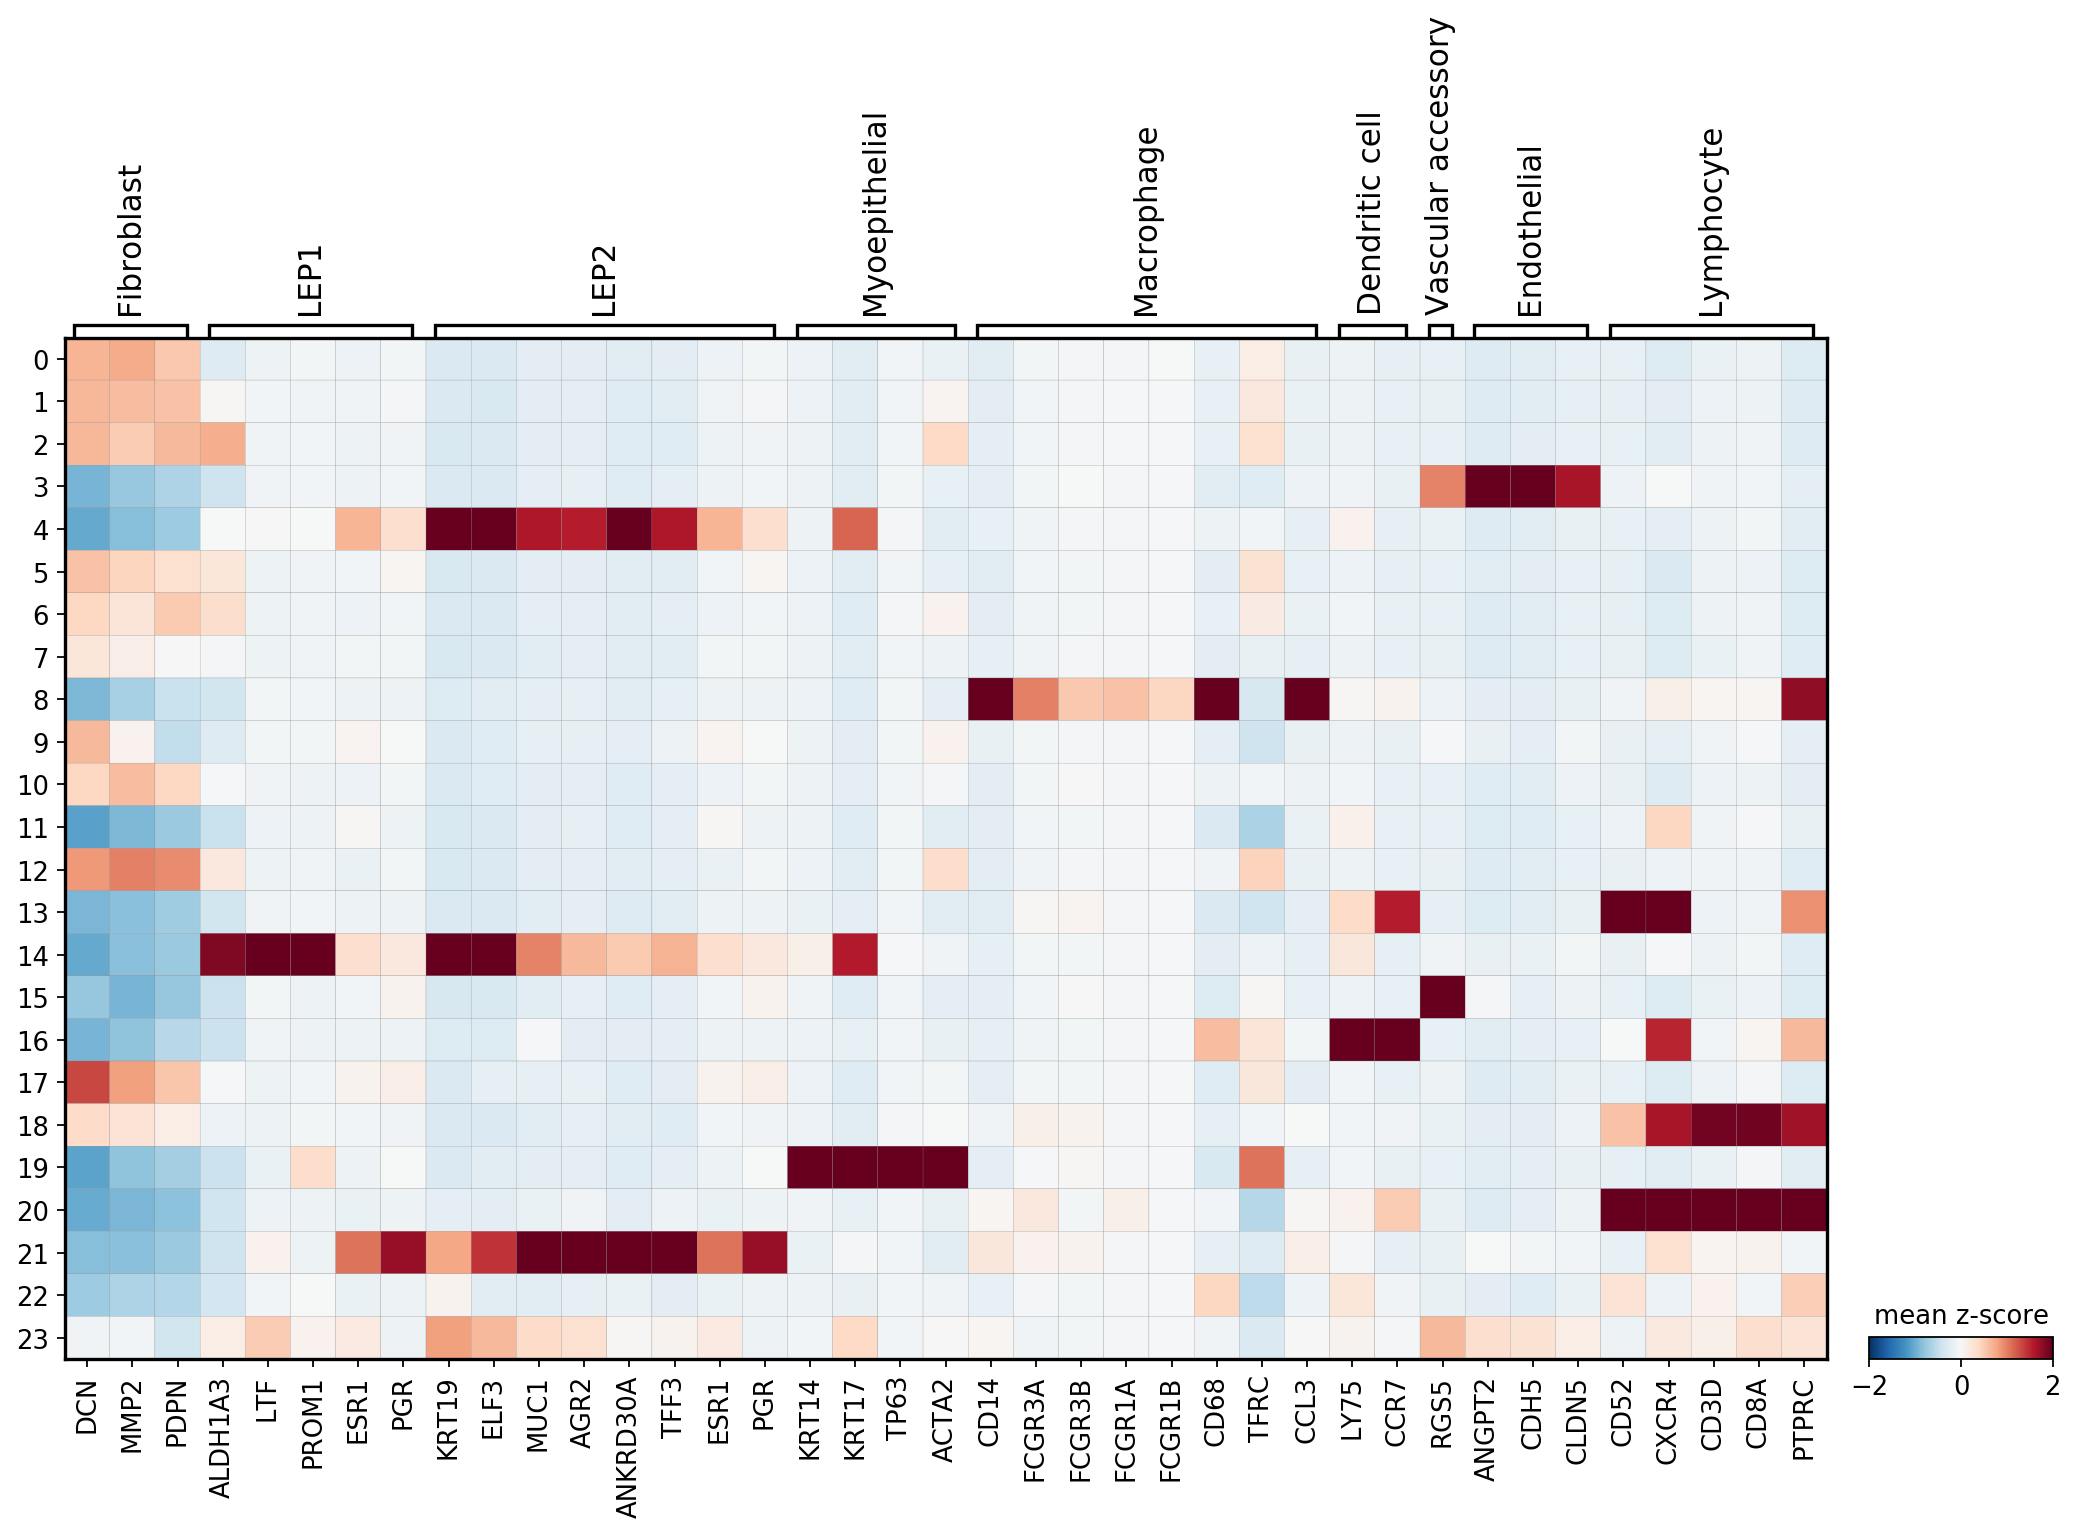

In [47]:
## leiden clustering (leiden resolution and the number of clusters is randomly chosen as we do not know the number of distinct cell types in the data set)
sc.tl.leiden(breast_pip,1)

## plot leiden clusters on PC1 vs. PC2
fig, axs = plt.subplots(1,2, figsize=(8,4), constrained_layout=True)
sc.pl.pca(breast_pip, color=["leiden"], alpha=.7, s=20, components="1,2",legend_loc='on data', ax=axs[0], show=False)
sc.pl.pca(breast_pip, color=["leiden"], alpha=.7, s=20, components="1,3",legend_loc='on data', ax=axs[1], show=False)

## plot leiden clusters on UMAP
sc.pl.umap(breast_pip, color=['leiden'], legend_loc="on data")

## dot plot to assign cell types to clusters
sc.pl.dotplot(breast_pip, breast_marker_genes_dict_pip, 'leiden', use_raw = False)
sc.pl.dotplot(breast_pip, breast_marker_genes_dict_pip, 'leiden', use_raw = False, standard_scale='var')

## matrix plot to assign cell types to clusters
breast_pip.layers["scaled"] = sc.pp.scale(breast_pip, copy=True).X
sc.pl.matrixplot(breast_pip, breast_marker_genes_dict_pip, 'leiden', dendrogram=False, colorbar_title='mean z-score', layer='scaled', vmin=-2, vmax=2, cmap='RdBu_r')

In [48]:
## assign cell types
cluster2annotation_pip = {
    "0": "Fibroblast",
    "1": "Fibroblast",
    "2": "Fibroblast",
    "3": "Endothelial",
    "4": "LEP2",
    "5": "Fibroblast",
    "6": "Fibroblast",
    "7": "Fibroblast",
    "8": "Macrophage",
    "9": "Fibroblast",
    "10": "Fibroblast",
    "11": "Unknown 1",
    "12": "Fibroblast",
    "13": "Lymphocyte",
    "14": "LEP1",
    "15": "Vascular accessory",
    "16": "Dendritic cell",
    "17": "Fibroblast",
    "18": "Lymphocyte",
    "19": "Myoepithelial",
    "20": "Lymphocyte",
    "21": "LEP2",
    "22": "Unknown 2",
    "23": "Unknown 3"
}

breast_pip.obs['celltype'] = breast_pip.obs['leiden'].map(cluster2annotation_pip).astype('category')

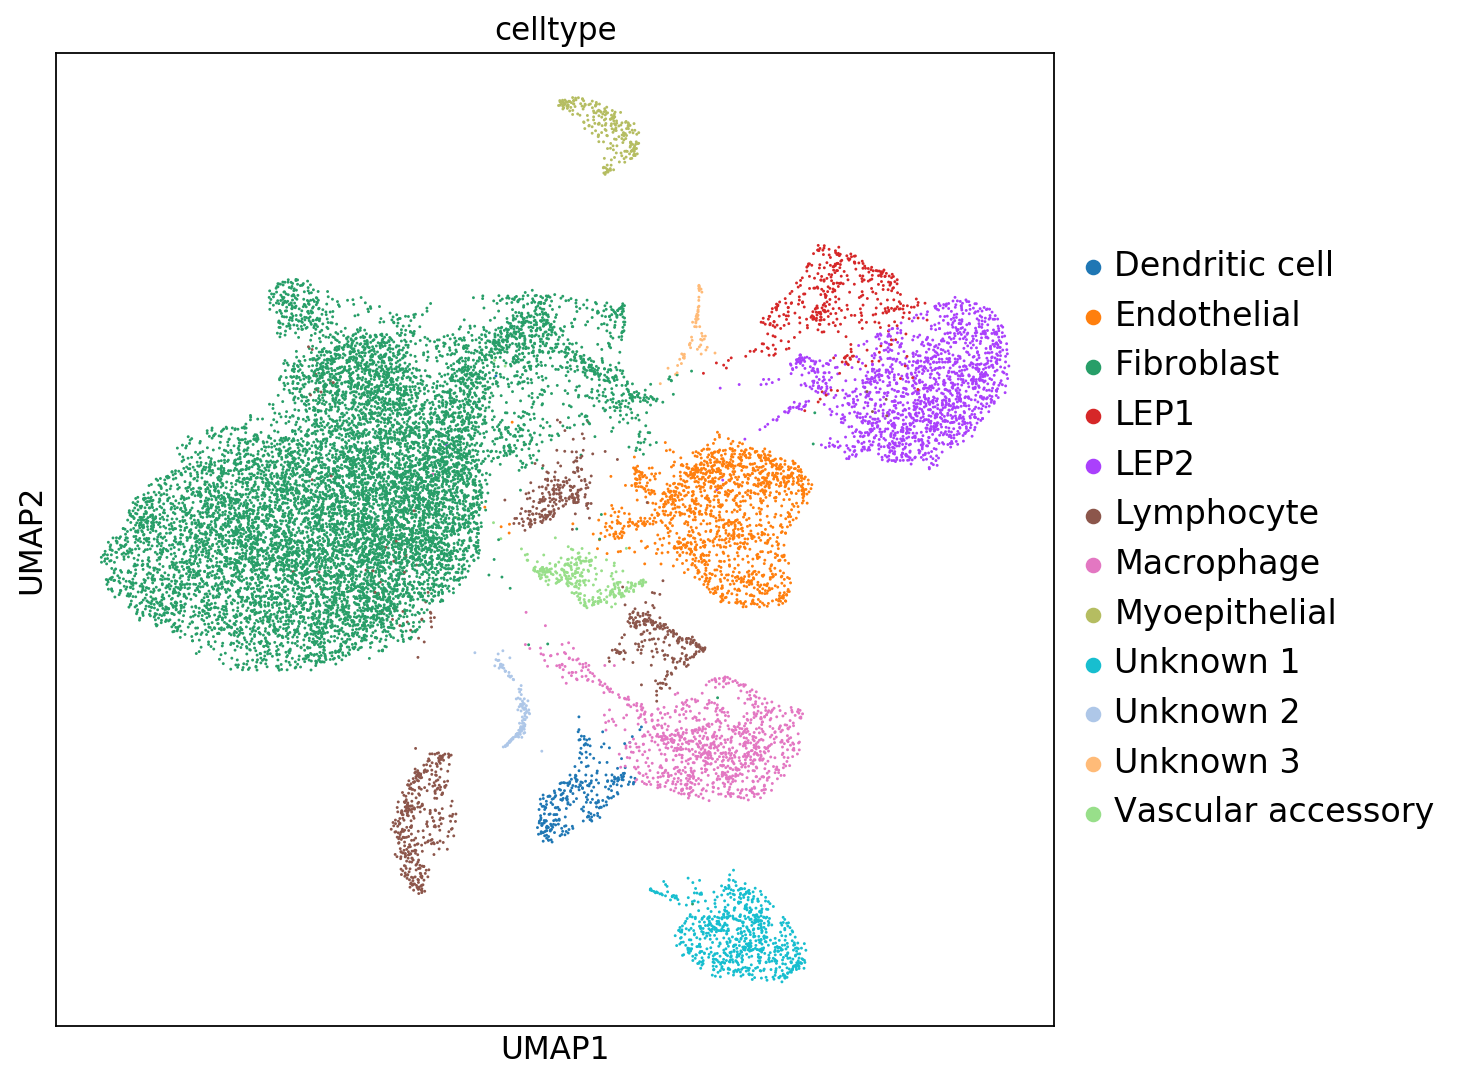

In [49]:
# plot UMAP based on annotated cell types
sc.set_figure_params(figsize="8, 8")
sc.pl.umap(breast_pip, color='celltype', legend_loc='right margin', legend_fontsize=15, legend_fontoutline=0)
sc.set_figure_params()

In [50]:
## run Wilcoxon rank-sum test
sc.tl.rank_genes_groups(breast_pip, 'celltype', method='wilcoxon', key_added = 'wilcoxon', random_state = seed, use_raw = False)

/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:420: 

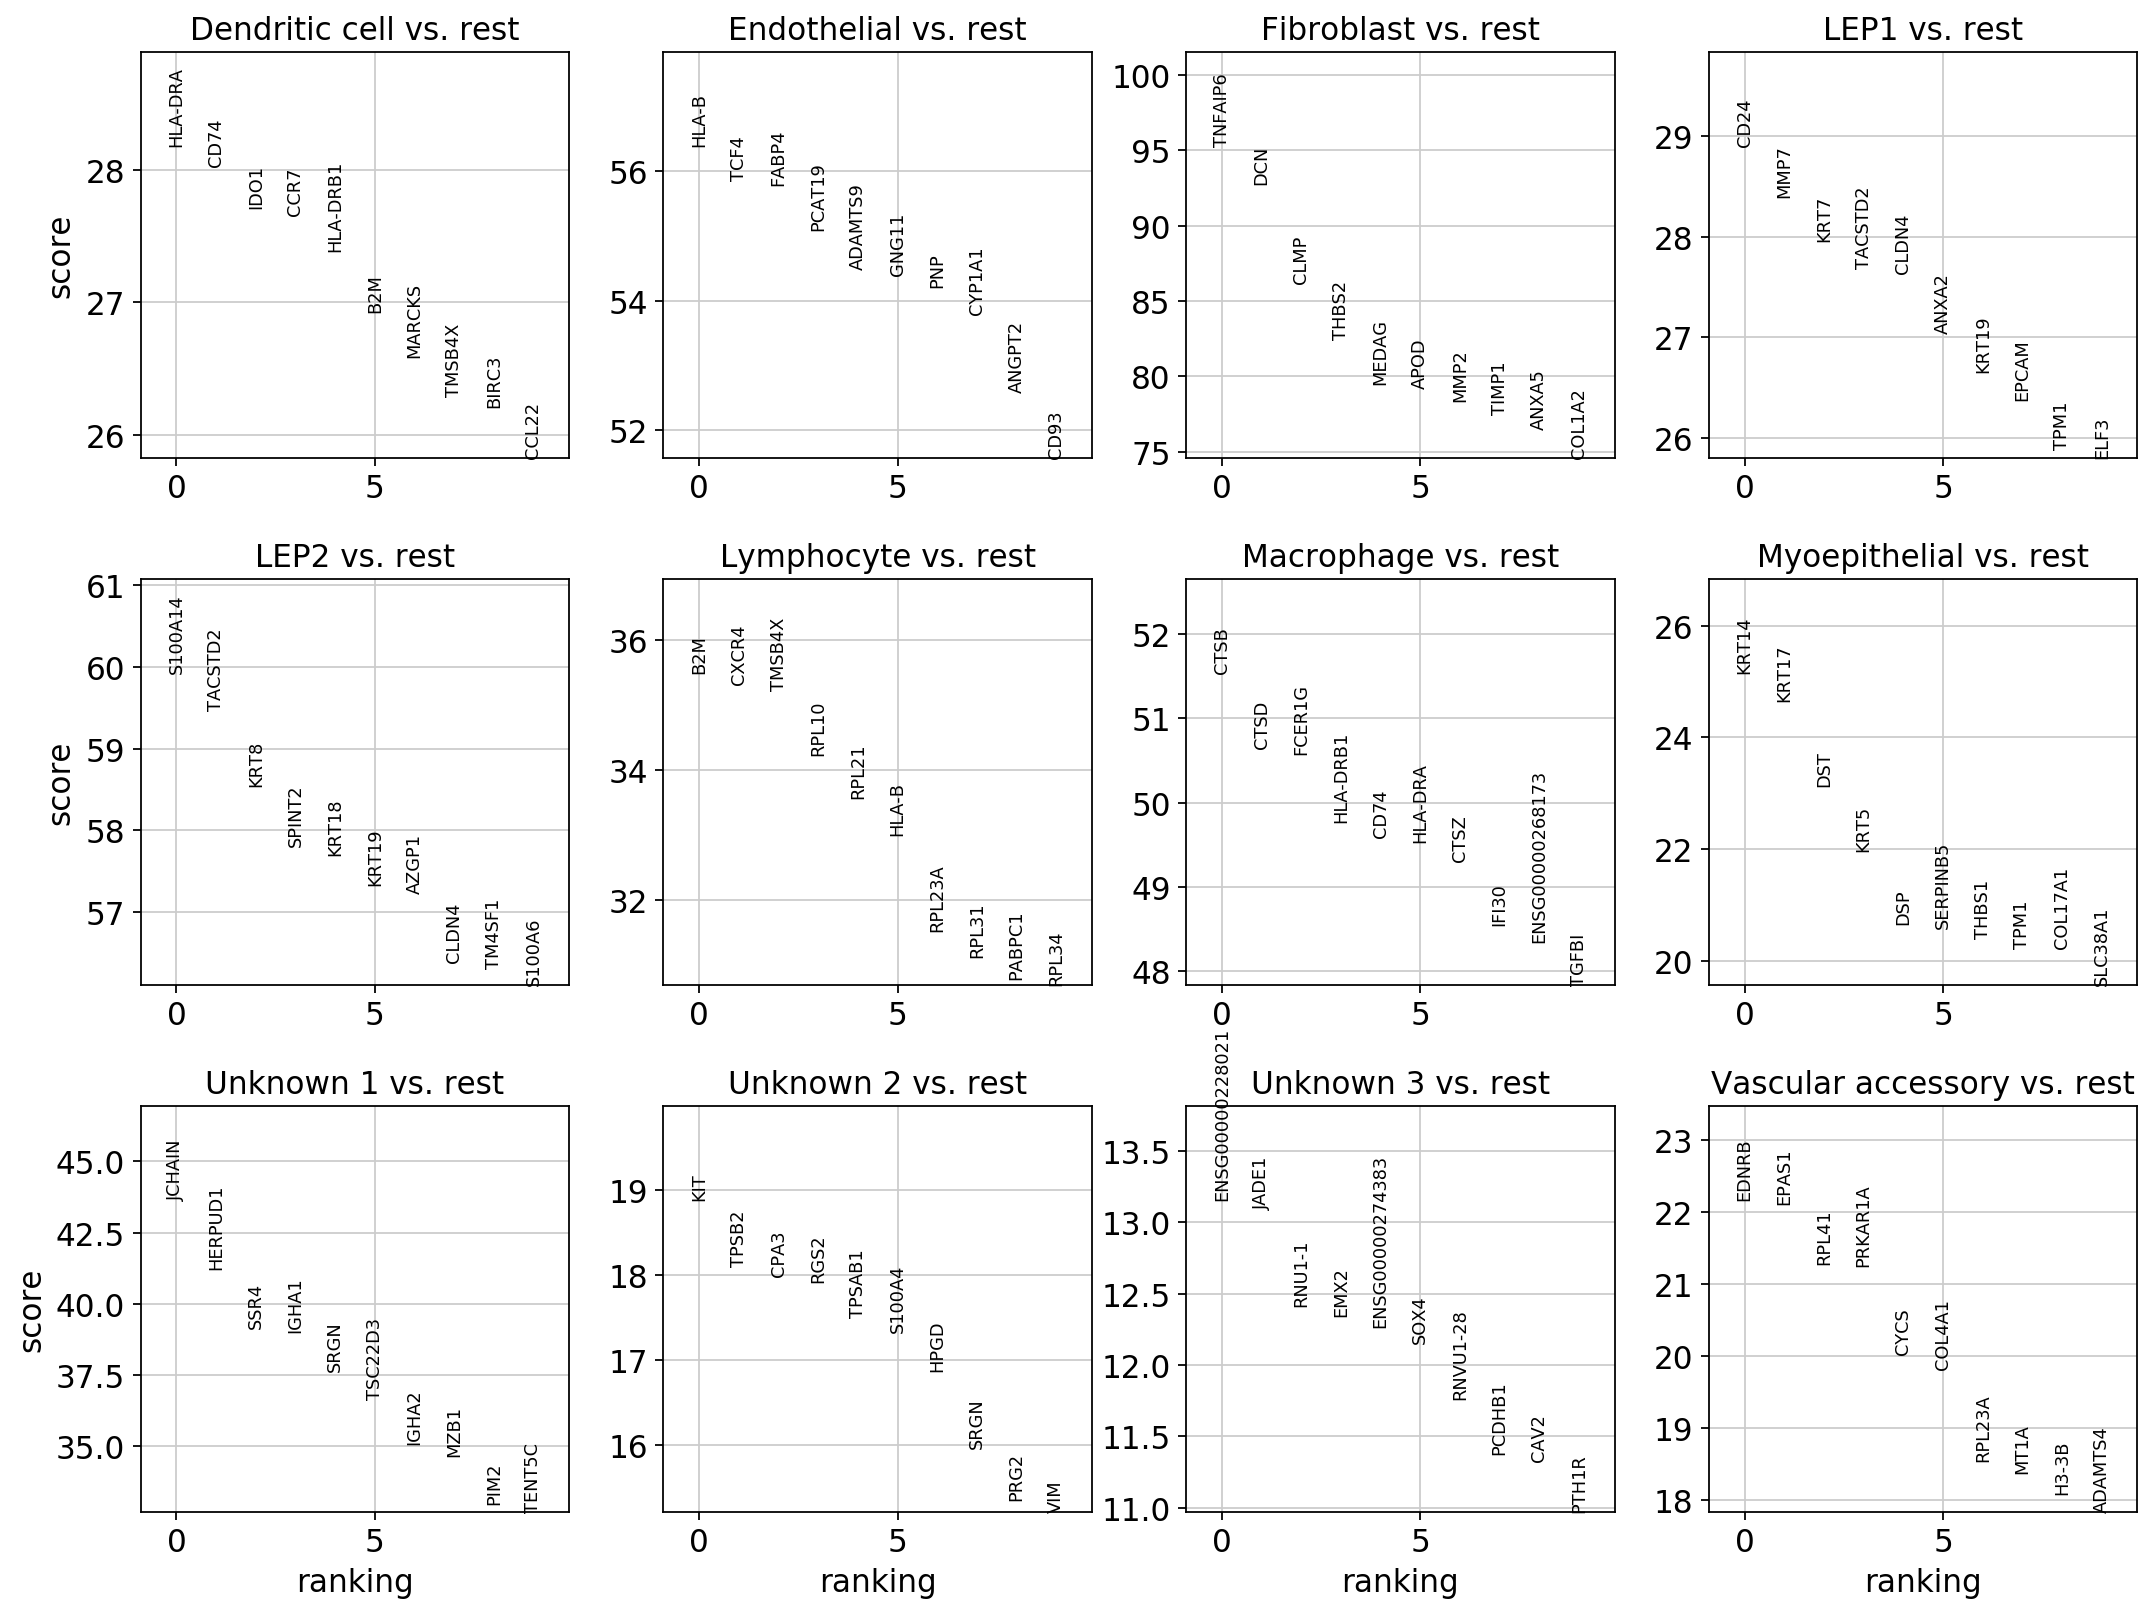

In [51]:
# plot top 10 differentially expressed for each cluster vs. rest
sc.pl.rank_genes_groups(breast_pip, n_genes = 10, sharey = False, key = 'wilcoxon')

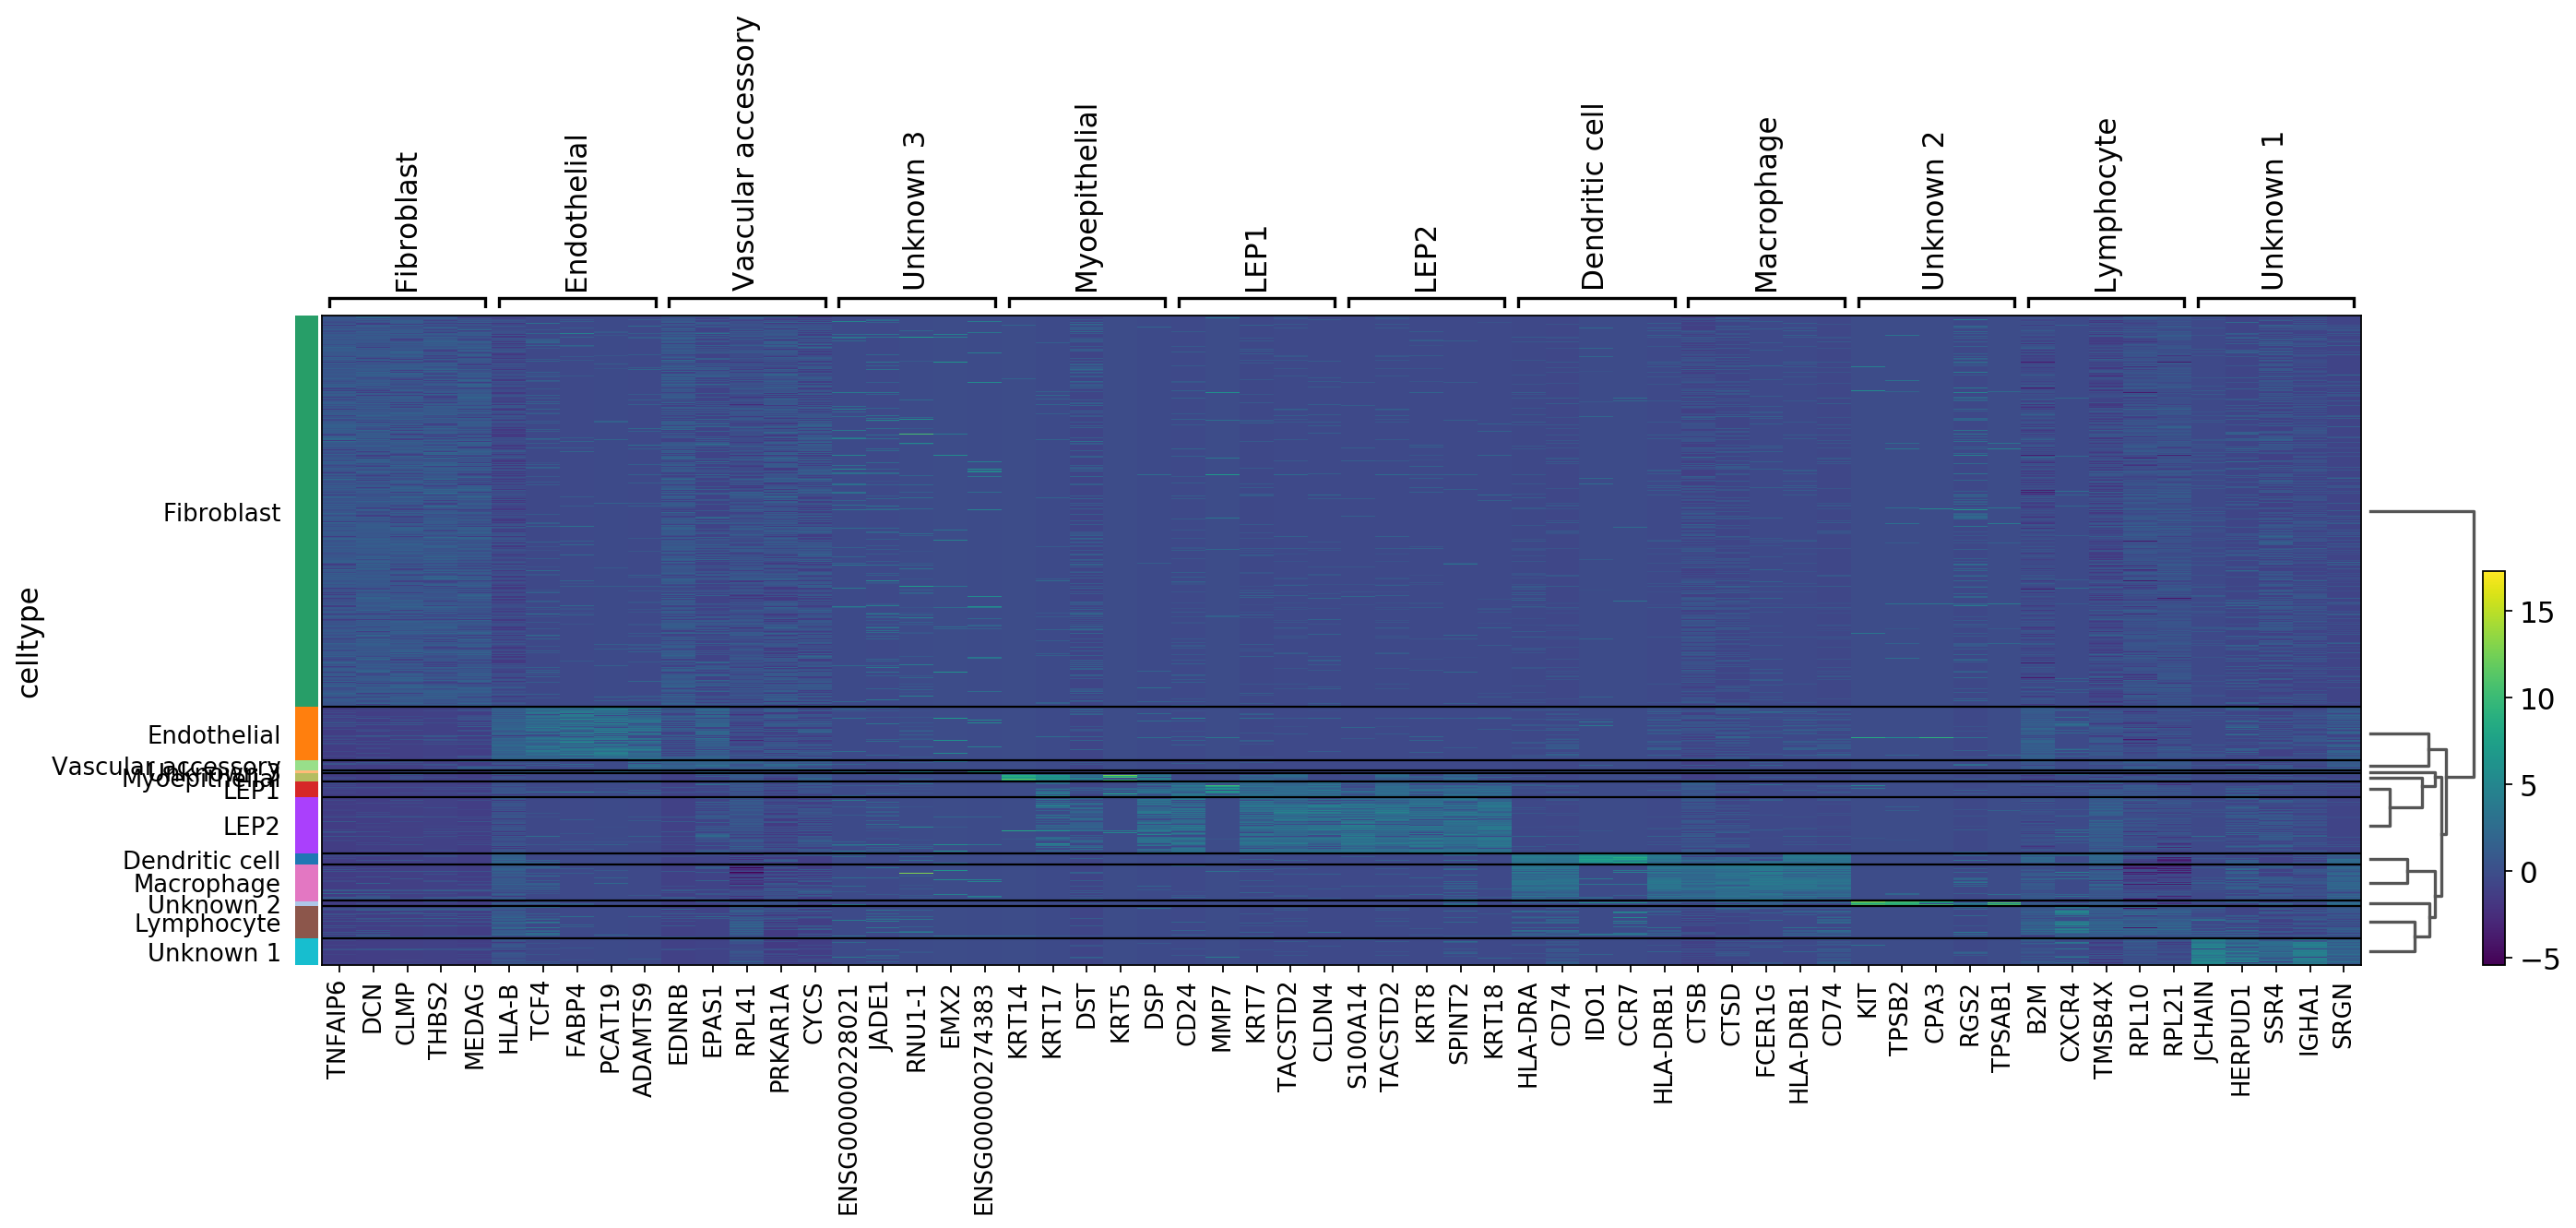

In [52]:
# visualize top differentially expressed genes for each cluster as a heatmap
sc.pl.rank_genes_groups_heatmap(breast_pip, n_genes = 5, key = 'wilcoxon', groupby = 'celltype', show_gene_labels = True, use_raw = False)

### Comparison between two data sets

In [ ]:
## concatenate

### Export data sets with celltype labels

In [60]:
breast_10x_celltype_labeled = sc.read_h5ad('/content/gdrive/MyDrive/CSCB final/breast_10x_preanalysis.h5ad')
breast_pip_celltype_labeled = sc.read_h5ad('/content/gdrive/MyDrive/CSCB final/breast_pip_preanalysis.h5ad')

## add celltype annotations
breast_10x_celltype_labeled.obs["celltype"] = breast_10x.obs["celltype"]
breast_pip_celltype_labeled.obs["celltype"] = breast_pip.obs["celltype"]

/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationW

In [64]:
breast_10x_celltype_labeled.write('/content/gdrive/MyDrive/CSCB final/breast_10x_celltype_labeled.h5ad')
breast_pip_celltype_labeled.write('/content/gdrive/MyDrive/CSCB final/breast_pip_celltype_labeled.h5ad')